# DSCI 552 | Homework 3 - AReM Data

### Time Series Classification Part 1: Feature Creation/Extraction

| Key             | Value           |
| --------------- | --------------- |
| Submitted By    | Ruchit Bhardwaj |
| USC ID          | 1111-4177-99    |
| Github Username | ruch0401        |


An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

**1(a). Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29. The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg_rss12, var_rss12, avg_rss13, var_rss13,vg_rss23, and ar_rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values**

In [1]:
# performing all imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import re
import csv
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Setting variables to be used globally
COLUMN_NAMES = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
OG_COLUMN_NAMES = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
ORDERED_STATS = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
ROOT = '../data/AReM/'
sniffer = csv.Sniffer()

**1(b). Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.**

In [3]:
# function to split data files into train and test files
def split_train_test(root):
    train = []
    test = []
    for root, dir, file in os.walk(root):
        for f in file:
            if 'pdf' not in f:                
                fpof = os.path.join(root, f)
                if 'bending1' in fpof or 'bending2' in fpof:
                    if 'dataset1.csv' in fpof or 'dataset2.csv' in fpof:
                        test.append(fpof)
                    else:
                        train.append(fpof)
                else:
                    if 'dataset1.csv' in fpof or 'dataset2.csv' in fpof or 'dataset3.csv' in fpof:
                        test.append(fpof)
                    else:
                        train.append(fpof)
    return train, test

In [4]:
train, test = split_train_test(ROOT)

In [5]:
train

['../data/AReM/bending1/dataset7.csv',
 '../data/AReM/bending1/dataset6.csv',
 '../data/AReM/bending1/dataset4.csv',
 '../data/AReM/bending1/dataset5.csv',
 '../data/AReM/bending1/dataset3.csv',
 '../data/AReM/walking/dataset7.csv',
 '../data/AReM/walking/dataset6.csv',
 '../data/AReM/walking/dataset4.csv',
 '../data/AReM/walking/dataset5.csv',
 '../data/AReM/walking/dataset10.csv',
 '../data/AReM/walking/dataset11.csv',
 '../data/AReM/walking/dataset13.csv',
 '../data/AReM/walking/dataset12.csv',
 '../data/AReM/walking/dataset15.csv',
 '../data/AReM/walking/dataset14.csv',
 '../data/AReM/walking/dataset8.csv',
 '../data/AReM/walking/dataset9.csv',
 '../data/AReM/bending2/dataset6.csv',
 '../data/AReM/bending2/dataset4.csv',
 '../data/AReM/bending2/dataset5.csv',
 '../data/AReM/bending2/dataset3.csv',
 '../data/AReM/standing/dataset7.csv',
 '../data/AReM/standing/dataset6.csv',
 '../data/AReM/standing/dataset4.csv',
 '../data/AReM/standing/dataset5.csv',
 '../data/AReM/standing/dataset

In [6]:
test

['../data/AReM/bending1/dataset1.csv',
 '../data/AReM/bending1/dataset2.csv',
 '../data/AReM/walking/dataset1.csv',
 '../data/AReM/walking/dataset2.csv',
 '../data/AReM/walking/dataset3.csv',
 '../data/AReM/bending2/dataset1.csv',
 '../data/AReM/bending2/dataset2.csv',
 '../data/AReM/standing/dataset1.csv',
 '../data/AReM/standing/dataset2.csv',
 '../data/AReM/standing/dataset3.csv',
 '../data/AReM/sitting/dataset1.csv',
 '../data/AReM/sitting/dataset2.csv',
 '../data/AReM/sitting/dataset3.csv',
 '../data/AReM/lying/dataset1.csv',
 '../data/AReM/lying/dataset2.csv',
 '../data/AReM/lying/dataset3.csv',
 '../data/AReM/cycling/dataset1.csv',
 '../data/AReM/cycling/dataset2.csv',
 '../data/AReM/cycling/dataset3.csv']

### 1(c). Feature Extraction. 
### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

**1c-i). Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).**

- maximum
- minimum
- mean
- median
- standard deviation
- first quartile
- third quartile
- correlation structure
- distribution
- entropy
- stationarity
- scaling properties

**1c-ii). Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.**

In [7]:
# parses the file and evaluates the label for all given instances
def get_label(file):
    parent_directory = os.path.dirname(file)
    filename_components = parent_directory.split("/")
    return filename_components[-1]

# finding the separator in the CSV file
def get_separator(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

# fetch all columns for the resultant dataset
def get_columns(segs=1):
    end = 6 * segs + 1
    feature = []
    for i in range(1, end):
        for stat in STATS:
            feature.append(f'{stat}{i}')
    return feature
    
# utility method to load the data after parsing the file
def load_data(files, feature, cols, segs=1, standard=False):
    import csv
    
    instances  = []
    labels = []
    for f in files:
        labels.append(get_label(f))
        separator = get_separator(f)
        
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        elif separator == "\\s+":
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
            
        fc.columns = OG_COLUMN_NAMES
        
        # breaking time series into equal lengths
        seg_length = int(fc.shape[0] / segs)
        description = []
        for i in range(segs):
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start1 : end1]
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
            
    # reordering
    feature_df = pd.DataFrame(instances)
    feature_df.columns = get_columns(segs)
    feature_df = feature_df.loc[:, feature]
    
    # label addition
    feature_df['label'] = pd.Series(labels)
    
    return feature_df

In [8]:
# fetching columns in a given order
def get_actual_ordered_cols():
    feature = []
    for i in range(1, 7):
        for stat in ORDERED_STATS:
            feature.append(f'{stat}{i}')
    return feature

In [9]:
feature = get_actual_ordered_cols()

train_data = load_data(train, feature, OG_COLUMN_NAMES)
test_data = load_data(test, feature, OG_COLUMN_NAMES)

In [10]:
train_data

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   36.25  48.00  43.969125    44.50  1.618364         43.310          44.67   
1   37.00  48.00  43.454958    43.25  1.386098         42.500          45.00   
2   33.00  47.75  42.179813    43.50  3.670666         39.150          45.00   
3   33.00  45.75  41.678063    41.75  2.243490         41.330          42.75   
4   35.00  47.40  43.954500    44.33  1.558835         43.000          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  18.50  44.25  35.752354    36.00  4.614802         33.000          39.33   
65  24.25  45.00  37.177042    36.25  3.581301         34.500          40.25   
66  23.33  43.50  36.248768    36.75  3.824632         33.415          39.25   
67  26.25  44.25  36.957458    36.29  3.434863         34.500          40.25   
68  27.75  44.67  37.144833    36.33  3.758904         34.000          40.50   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6   max6  \
0    0.0   1.50  0.413125  ...        20.5000        23.7500   0.0   2.96   
1    0.0   1.58  0.378083  ...        22.2500        24.0000   0.0   5.26   
2    0.0   3.00  0.696042  ...        30.4575        36.3300   0.0   2.18   
3    0.0   2.83  0.535979  ...        28.4575        31.2500   0.0   1.79   
4    0.0   1.70  0.426250  ...        35.3625        36.5000   0.0   1.79   
..   ...    ...       ...  ...            ...            ...   ...    ...   
64   0.0  12.60  3.328104  ...        14.0000        18.0625   0.0   9.39   
65   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0   9.34   
66   0.0   9.71  2.737307  ...        15.7500        21.0000   0.0  11.15   
67   0.0   8.64  2.420083  ...        14.0000        18.2500   0.0   8.34   
68   0.0  10.76  2.419062  ...        15.0000        18.7500   0.0   8.75   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.555313    0.490  0.487826         0.0000          0.830  bending1  
1   0.679646    0.500  0.622534         0.4300          0.870  bending1  
2   0.613521    0.500  0.524317         0.0000          1.000  bending1  
3   0.383292    0.430  0.389164         0.0000          0.500  bending1  
4   0.493292    0.430  0.513506         0.0000          0.940  bending1  
..       ...      ...       ...            ...            ...       ...  
64  3.069667    2.770  1.748326         1.7975          4.060   cycling  
65  2.921729    2.500  1.852600         1.5000          3.900   cycling  
66  3.532463    3.110  1.965267         2.1700          4.625   cycling  
67  2.934625    2.525  1.631380         1.6600          4.030   cycling  
68  2.822437    2.590  1.637183         1.5800          3.740   cycling  

[69 rows x 43 columns]

In [11]:
test_data

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   37.25  45.00  40.624792   40.500  1.476967        39.2500        42.0000   
1   38.00  45.67  42.812812   42.500  1.435550        42.0000        43.6700   
2   19.33  43.50  34.227771   35.500  4.889576        30.5000        37.7500   
3   12.50  45.00  33.509729   34.125  4.850923        30.5000        36.7500   
4   15.00  46.75  34.660583   35.000  5.315110        31.0000        38.2500   
5   12.75  51.00  24.562958   24.250  3.737514        23.1875        26.5000   
6    0.00  42.75  27.464604   28.000  3.583582        25.5000        30.0000   
7   33.33  48.00  44.334729   45.000  2.476940        42.2500        46.5000   
8   35.50  46.25  43.174938   43.670  1.989052        42.5000        44.5000   
9   32.75  47.00  42.760563   44.500  3.398919        41.3300        45.3725   
10  33.25  48.00  42.363563   43.000  2.068247        42.0000        43.5000   
11  37.00  50.75  45.917667   45.635  1.089027        45.0000        46.5000   
12  44.50  46.75  45.239667   45.000  0.429915        45.0000        45.3300   
13  23.50  30.00  27.716375   27.500  1.442253        27.0000        29.0000   
14  24.75  48.33  44.182937   48.000  7.495615        48.0000        48.0000   
15  48.00  48.25  48.004167   48.000  0.032038        48.0000        48.0000   
16  24.25  45.00  37.177042   36.250  3.581301        34.5000        40.2500   
17  28.75  44.75  37.561188   36.875  3.226507        35.2500        40.2500   
18  22.00  44.67  37.058708   36.000  3.710180        34.5000        40.0625   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6  max6  \
0    0.0   1.30  0.358604  ...        33.0000        36.0000   0.0  1.92   
1    0.0   1.22  0.372438  ...        32.0000        34.5000   0.0  3.11   
2    0.0  14.50  3.995729  ...        14.7500        18.6700   0.0  9.74   
3    0.0  13.05  4.450771  ...        14.6275        18.7500   0.0  8.96   
4    0.0  13.44  4.200896  ...        14.2500        18.5000   0.0  8.99   
5    0.0   6.87  0.590833  ...        20.5000        27.0000   0.0  4.97   
6    0.0   7.76  0.449708  ...        15.0000        20.7500   0.0  6.76   
7    0.0   3.90  0.432958  ...         9.3300        17.7500   0.0  5.02   
8    0.0   2.12  0.506583  ...        12.7500        16.5000   0.0  5.72   
9    0.0   3.34  0.486167  ...        13.0000        18.5650   0.0  5.73   
10   0.0   4.44  0.492563  ...        10.1875        17.6900   0.0  6.02   
11   0.0   4.87  0.324542  ...        16.5000        21.0000   0.0  7.22   
12   0.0   1.00  0.172958  ...        17.6275        21.0000   0.0  8.20   
13   0.0   1.79  0.363688  ...         5.5000        10.7500   0.0  4.50   
14   0.0   3.11  0.101875  ...         2.0000         5.5425   0.0  3.91   
15   0.0   0.43  0.007167  ...         4.6700        10.0000   0.0  2.50   
16   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0  9.34   
17   0.0   9.91  2.080688  ...        18.0000        21.5000   0.0  9.62   
18   0.0  14.17  2.438146  ...        16.0000        21.0000   0.0  8.55   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.570583    0.430  0.582915         0.0000          1.300  bending1  
1   0.571083    0.430  0.601010         0.0000          1.300  bending1  
2   3.394125    3.100  1.792090         2.1050          4.425   walking  
3   3.378479    3.085  1.787360         2.0600          4.440   walking  
4   3.244396    3.000  1.630983         2.1200          4.240   walking  
5   0.700188    0.500  0.693720         0.4300          0.870  bending2  
6   1.122125    0.830  1.012342         0.4700          1.300  bending2  
7   0.933000    0.830  0.673609         0.4700          1.250  standing  
8   0.911979    0.830  0.666161         0.4700          1.220  standing  
9   0.842271    0.710  0.722165         0.4300          1.090  standing  
10  1.034021    0.830  0.985627         0.4700          1.250   sitti

**1c-iii). Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.**

In [12]:
train_data.describe().loc['std']

min1             8.794295
max1             4.429182
mean1            4.917678
median1          4.956111
std1             1.758647
1st_quartile1    5.731647
3rd_quartile1    4.783645
min2             0.000000
max2             5.147841
mean2            1.600675
median2          1.436903
std2             0.902805
1st_quartile2    0.952201
3rd_quartile2    2.158258
min3             3.053869
max3             4.759853
mean3            3.863099
median3          3.845730
std3             0.995975
1st_quartile3    4.145255
3rd_quartile3    3.946023
min4             0.000000
max4             2.302408
mean4            1.179837
median4          1.150092
std4             0.473545
1st_quartile4    0.842501
3rd_quartile4    1.566564
min5             5.368786
max5             5.449726
mean5            5.120450
median5          5.267414
std5             1.057972
1st_quartile5    5.543882
3rd_quartile5    4.957231
min6             0.051766
max6             2.540166
mean6            1.171353
median6     

In [13]:
test_data.describe().loc['std']

min1             12.136206
max1              4.379342
mean1             6.790086
median1           7.088085
std1              1.869285
1st_quartile1     7.673052
3rd_quartile1     6.385720
min2              0.000000
max2              4.870395
mean2             1.500529
median2           1.345903
std2              0.832472
1st_quartile2     0.941307
3rd_quartile2     2.028482
min3              2.644618
max3              5.393220
mean3             4.588252
median3           4.753522
std3              0.760779
1st_quartile3     4.554121
3rd_quartile3     5.014339
min4              0.000000
max4              1.733937
mean4             1.146338
median4           1.161705
std4              0.409008
1st_quartile4     0.867088
3rd_quartile4     1.541943
min5              8.252947
max5              6.782153
mean5             7.366781
median5           7.438749
std5              0.919274
1st_quartile5     7.823870
3rd_quartile5     7.259433
min6              0.000000
max6              2.505306
m

In [14]:
# building 90% confidence interval
data = train_data.iloc[:, :-1]
ans = []
for sample in range(1000):
    resampled = resample(data)
    temp = resampled.apply(lambda col: np.std(col))
    ans.append(temp)

ans = pd.DataFrame(ans)
ans.columns = list(data.columns)
interval = ans.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
interval.apply(np.around, args=(2,))
interval = interval.T
interval.columns = ['5%', '95%']
interval


5%       95%
min1           7.409467  9.938418
max1           3.282469  5.376684
mean1          4.283306  5.399053
median1        4.279544  5.464204
std1           1.545701  1.932822
1st_quartile1  5.083529  6.171601
3rd_quartile1  3.877957  5.522959
min2           0.000000  0.000000
max2           4.614567  5.455498
mean2          1.389828  1.726076
median2        1.226084  1.571130
std2           0.802473  0.954863
1st_quartile2  0.811686  1.044152
3rd_quartile2  1.883753  2.312017
min3           2.793204  3.198913
max3           4.001591  5.316158
mean3          3.200064  4.348318
median3        3.163455  4.351466
std3           0.769189  1.193383
1st_quartile3  3.499530  4.630962
3rd_quartile3  3.265361  4.433439
min4           0.000000  0.000000
max4           2.057210  2.473036
mean4          1.069809  1.226076
median4        1.037787  1.196563
std4           0.428439  0.500190
1st_quartile4  0.758611  0.886245
3rd_quartile4  1.420267  1.629477
min5           3.409157  6.777353
max5           4.298249  6.338031
mean5          3.725603  6.278964
median5        3.750828  6.518218
std5           0.796425  1.294823
1st_quartile5  4.040189  6.772741
3rd_quartile5  3.602728  6.041104
min6           0.000000  0.087690
max6           2.181458  2.802686
mean6          1.057741  1.221160
median6        0.995467  1.156083
std6           0.469949  0.543264
1st_quartile6  0.693183  0.817165
3rd_quartile6  1.397062  1.615836

**1(c)(iv). Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)**

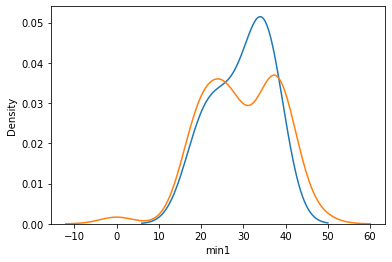

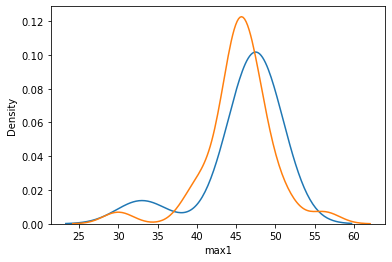

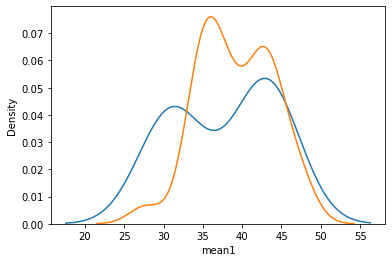

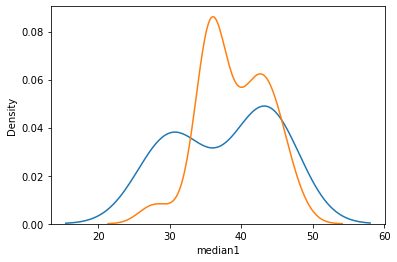

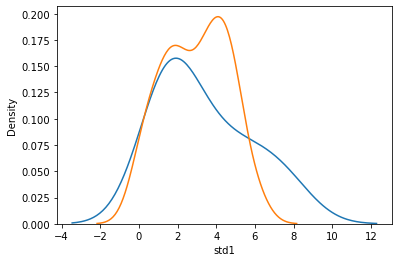

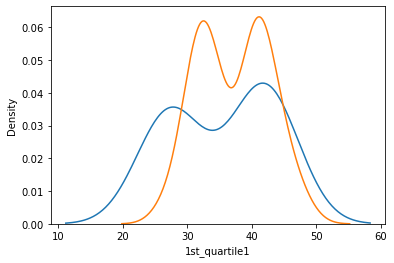

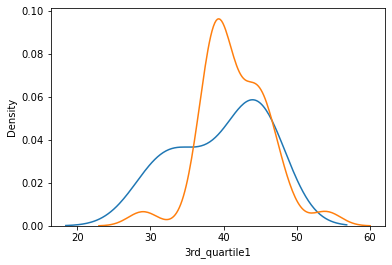

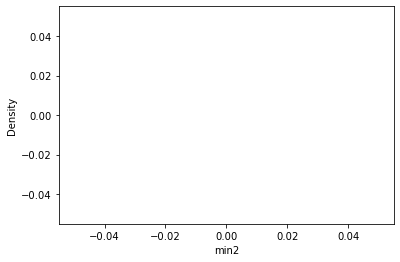

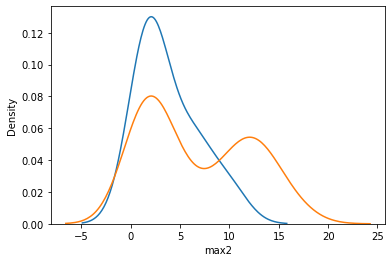

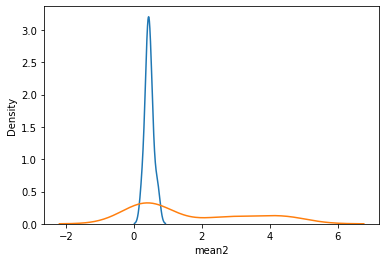

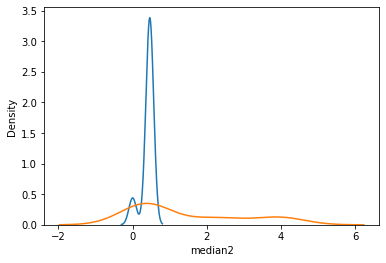

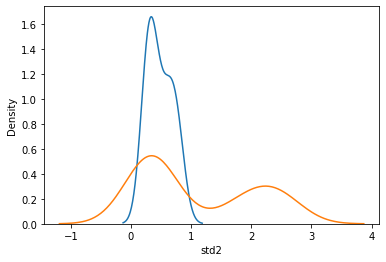

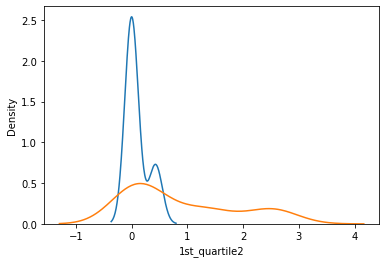

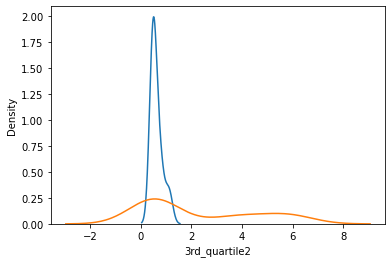

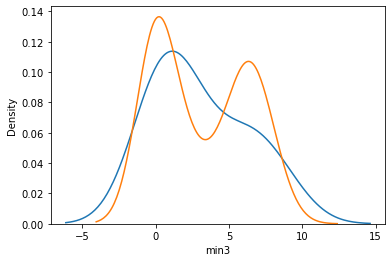

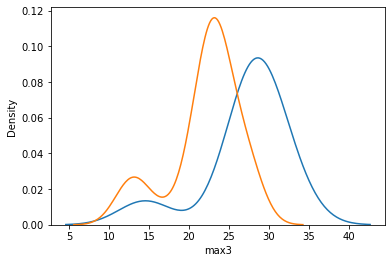

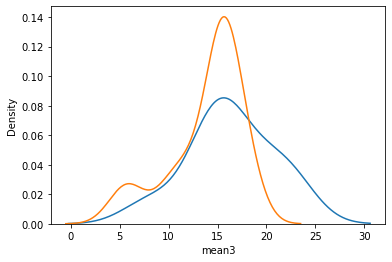

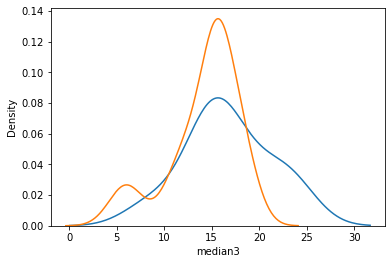

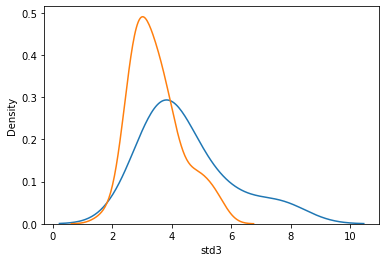

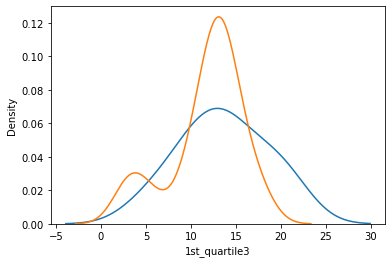

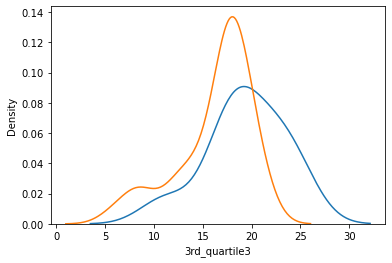

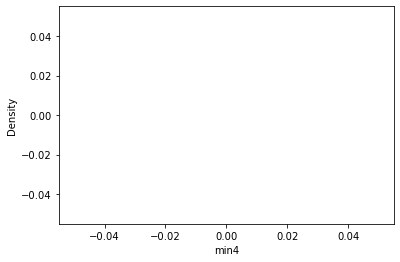

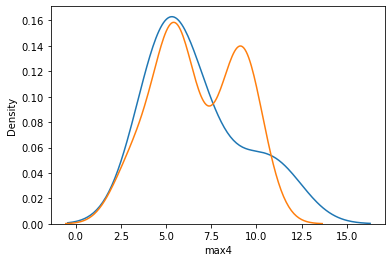

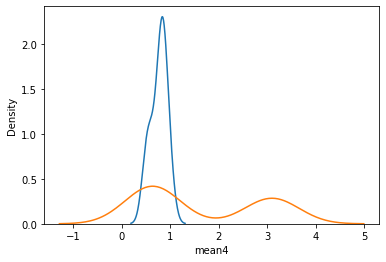

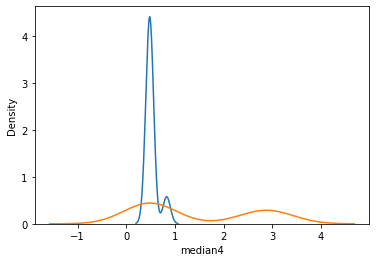

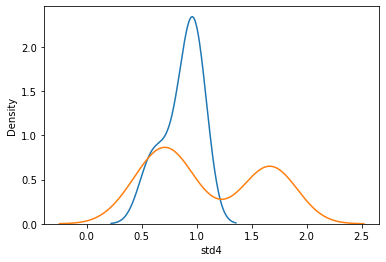

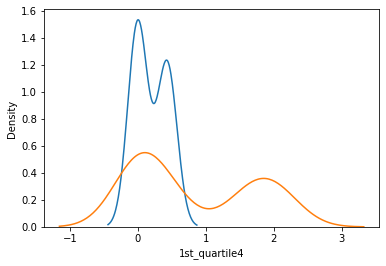

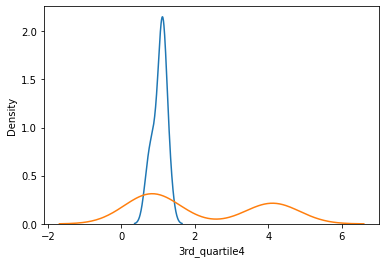

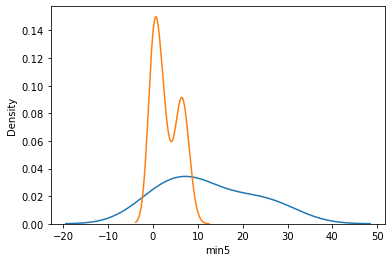

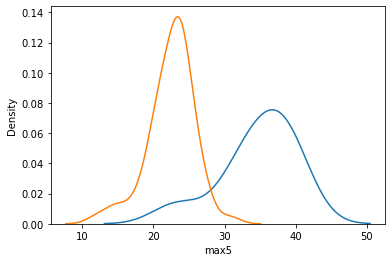

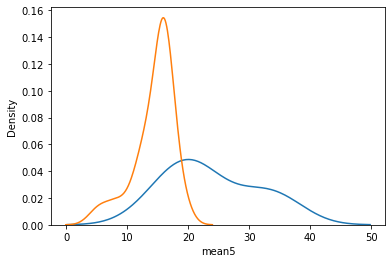

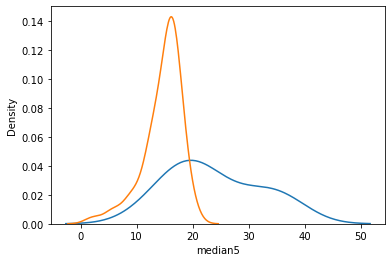

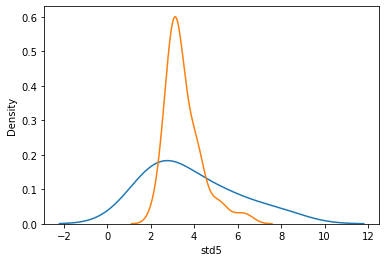

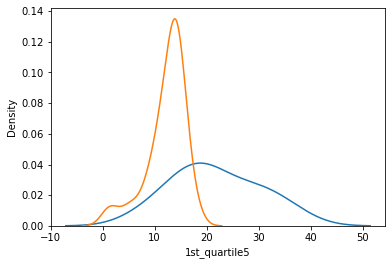

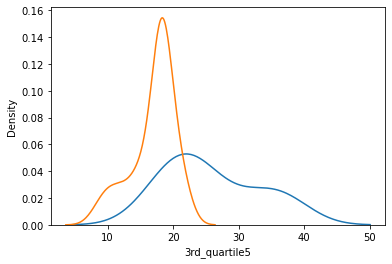

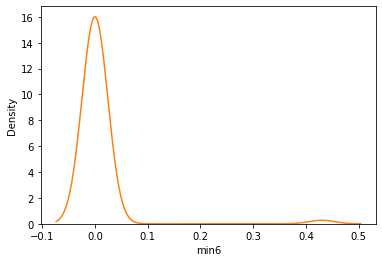

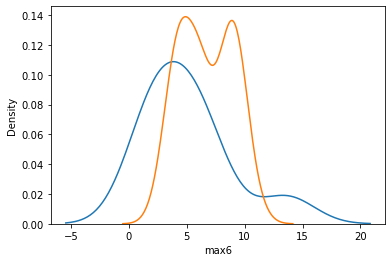

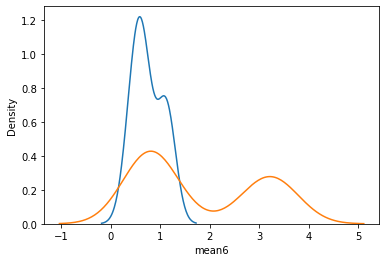

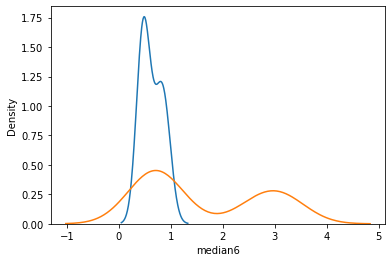

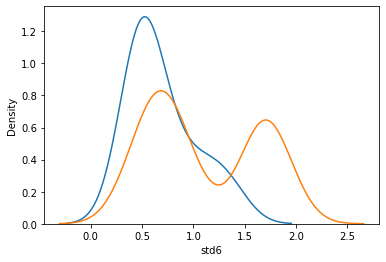

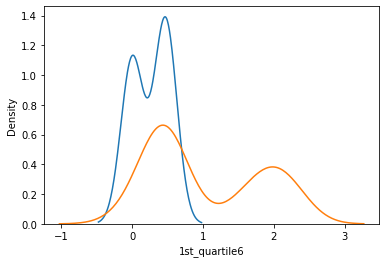

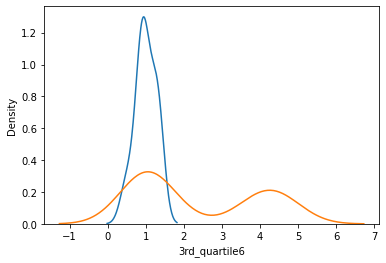

In [15]:
# converting label from text to 1 or 0 depending on whether the label is ('bending1', 'bending2') or not respectively
train_df = pd.DataFrame(train_data)
temp = train_df['label']
train_df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
train_df.loc[temp != 1, 'label'] = 0
train_data


    
for i in range(1, 7):
    for stat in ORDERED_STATS:
        bending_df = train_data.loc[train_data['label'] == 1, stat + str(i)]
        not_bending_df = train_data.loc[train_data['label'] == 0, stat + str(i)]
        sns.distplot(bending_df, label='Bending', kde='True', hist = False)
        sns.distplot(not_bending_df, label='Not Bending', kde='True', hist = False)
        plt.show()

Since this is a regression problem, the choice of important time-domain features will be majorly driven by the feasibility of demarkation and there should be relatively clear separated distribution and hence the choice would be - 
- max
- mean
- 3rd quartile

### 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Answer:** Since predictors are directly proportional to the fitting of the model, the RSS for linear regression would be higher as compared to the RSS for cubic regression since cubic regression has more predictors and thus would ideally have a better fit on a regression model.


(b) Answer (a) using test rather than training RSS.

**Answer:** More predictors generally leads to overfitting using the test data. So, for the test case, the RSS for linear regression will be lower since it is more likely to provide relatively correct regression result.


(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Answer:** The fundamental principle does not change. More predictors lead to less RSS and hence, the RSS for cubic would be less. Cubic regression has more flexibility.


(d) Answer (c) using test rather than training RSS.

**Answer:** The information provided is insufficient as the answer will depend on the finding of which regression is the actual answer closer to.

# HW4 - Time Series Classification Part 2: Binary and Multiclass Classification

## 2a) Binary Classification Using Logistic Regression

**2a.i) Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook).**

In [16]:
def get_cols(indexes, props):
    cols = []
    for index in indexes:
        for prop in props:
            col_name = prop + str(index)
            cols.append(col_name)
    return cols

def get_labelled_cols(df, cols):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return cols + ['label']

def plot_scatter_plot(df, hue_value):
    sns.pairplot(df, hue=hue_value)
#     plt.legend(title='Bending - Non-bending Classification', loc='upper left', labels=['Non-Bending', 'Bending'])
    plt.show()

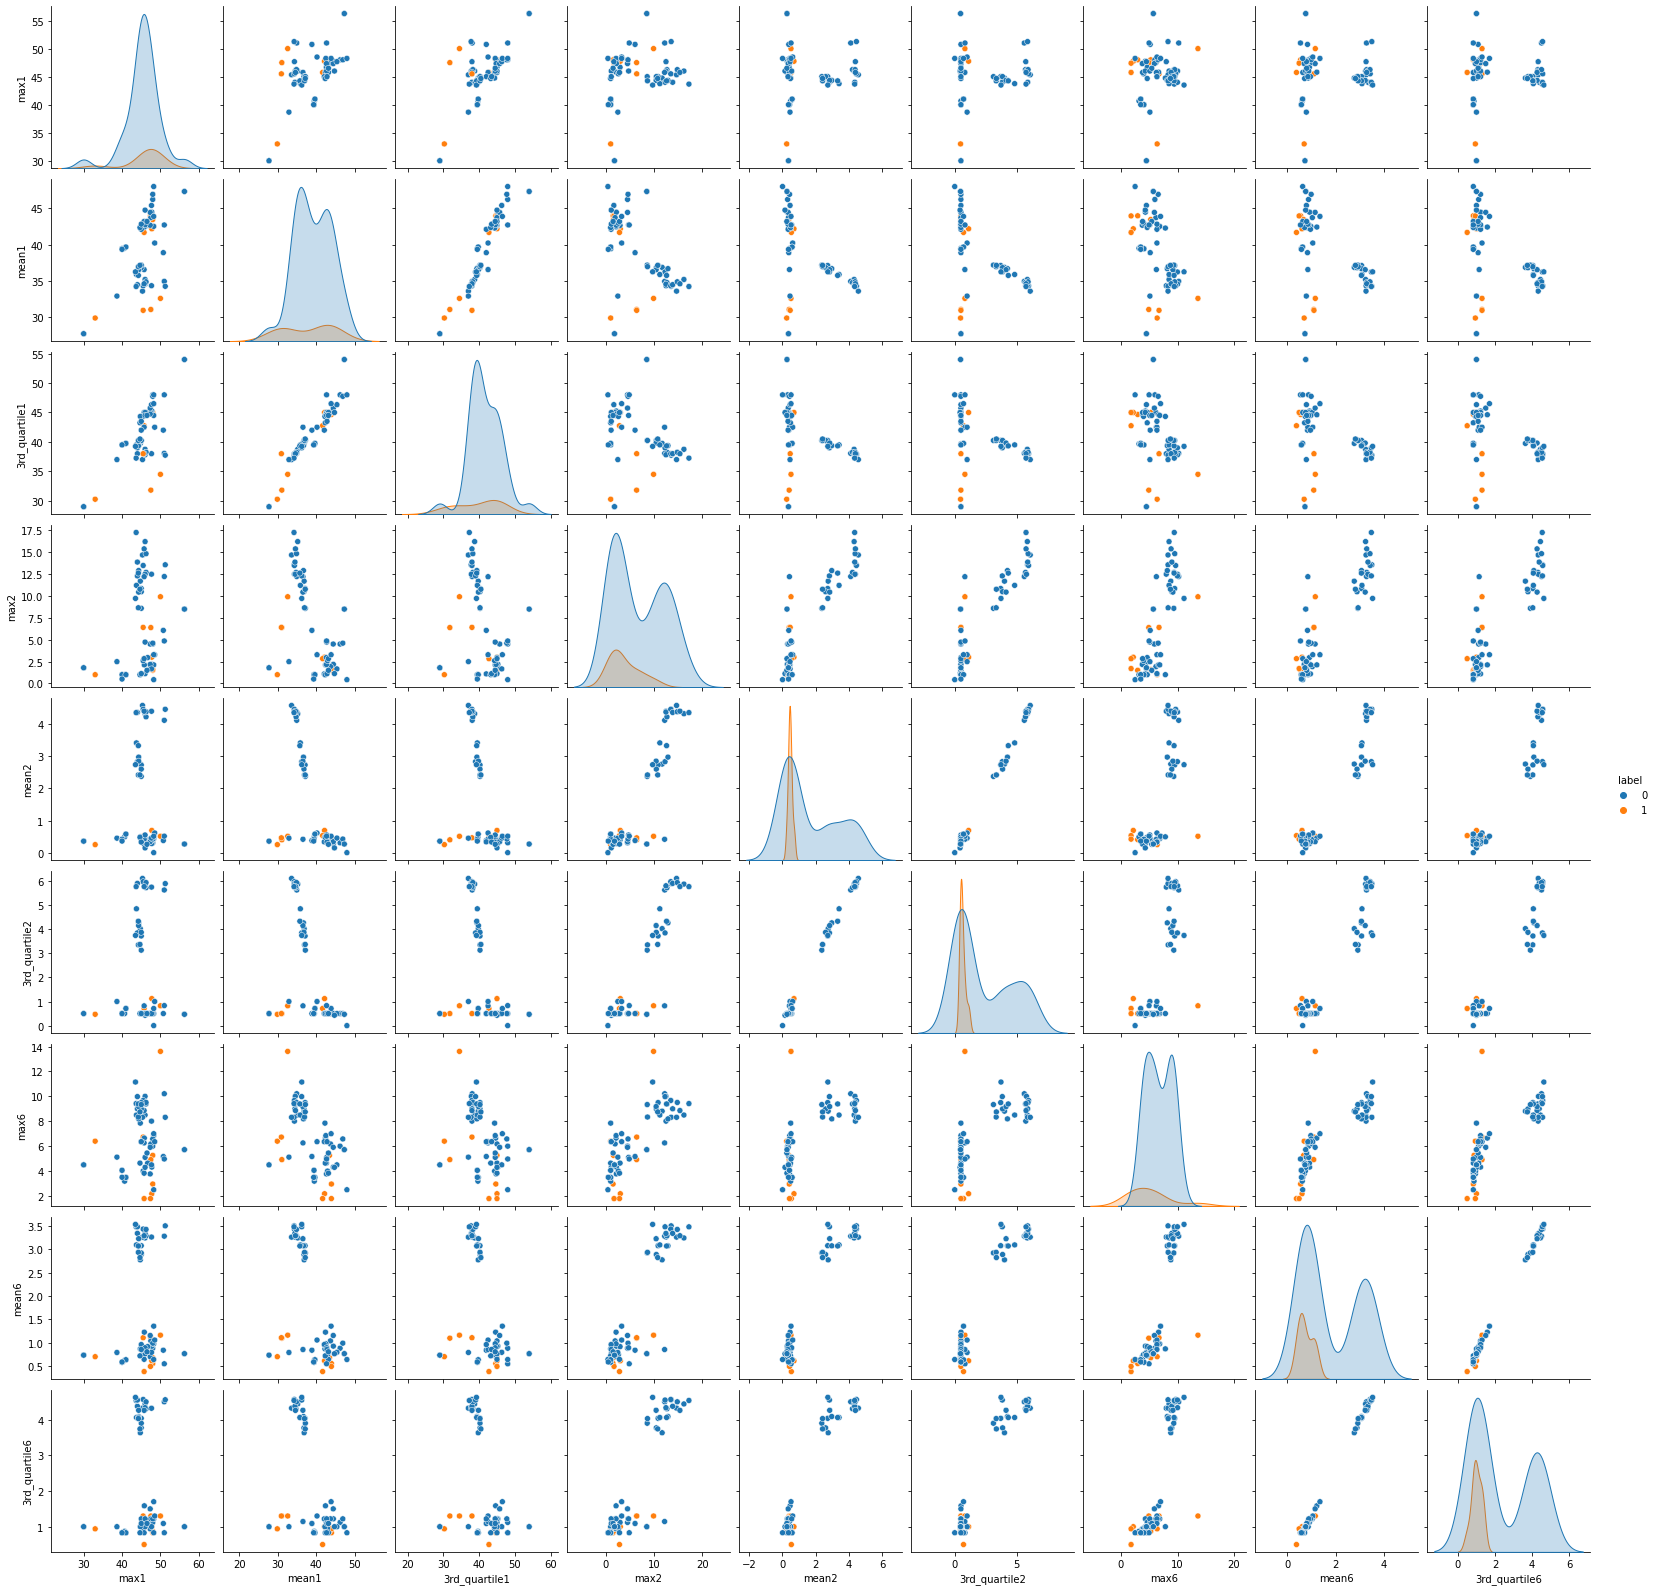

In [17]:
relevant_columns = get_cols([1, 2, 6], ['max', 'mean', '3rd_quartile'])
relevant_columns_labelled = get_labelled_cols(train_data, relevant_columns)
relevant_df = train_data[relevant_columns_labelled]
plot_scatter_plot(relevant_df, 'label')

**2a.ii) Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?**

In [18]:
# utility method to convert text labels into binary classified 0 and 1 labels
def get_binary_labelled_dataframe(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return df

In [19]:
features = []
for i in range(1, 13):
    for stat in ORDERED_STATS:
        col_name = f'{stat}{i}'
        features.append(col_name)

train_data_two = load_data(train, features, OG_COLUMN_NAMES, segs=2)
test_data_two = load_data(test, features, OG_COLUMN_NAMES, segs=2)

In [20]:
train_df_two = get_binary_labelled_dataframe(pd.DataFrame(train_data_two))
train_df_two

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   36.67  45.00  43.486208    43.71  1.281976        42.3300          44.50   
1   39.00  48.00  44.117042    45.00  1.359836        43.5000          45.00   
2   33.75  47.75  43.278875    45.00  3.473355        42.0000          45.25   
3   33.00  45.75  41.621208    42.33  3.118644        39.6525          44.25   
4   36.50  46.50  44.057167    44.50  1.556971        43.2500          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  20.00  44.25  35.692167    35.50  4.643595        33.0000          39.25   
65  24.25  45.00  36.954208    36.00  3.772836        34.2500          40.25   
66  27.00  42.67  36.337908    36.75  3.655379        33.6700          39.00   
67  26.25  43.40  36.865417    36.25  3.462793        34.3100          40.00   
68  27.75  44.00  37.144583    36.67  3.804785        34.0000          40.33   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0    0.0   1.30  0.378667  ...          21.000         23.5000    0.0   2.96   
1    0.0   1.30  0.250042  ...          22.500         23.7500    0.0   4.06   
2    0.0   3.00  0.673292  ...          28.750         33.7500    0.0   2.18   
3    0.0   2.83  0.623083  ...          28.310         30.5625    0.0   1.50   
4    0.0   1.50  0.381042  ...          33.000         36.2500    0.0   1.50   
..   ...    ...       ...  ...             ...             ...    ...    ...   
64   0.0  11.39  3.324208  ...          14.000         18.2500    0.0   8.81   
65   0.0   8.18  2.392667  ...          18.000         21.6700    0.0   9.34   
66   0.0   9.71  2.698494  ...          16.125         21.0000    0.0  11.15   
67   0.0   7.46  2.387250  ...          14.330         18.0000    0.0   8.34   
68   0.0  10.76  2.385708  ...          15.000         18.7500    0.0   7.93   

      mean12  median12     std12  1st_quartile12  3rd_quartile12  label  
0   0.585750      0.50  0.487918          0.4225          0.8300      1  
1   0.543875      0.50  0.473445          0.4300          0.7100      1  
2   0.586083      0.47  0.491873          0.0000          0.8700      1  
3   0.347500      0.43  0.363144          0.0000          0.5000      1  
4   0.388333      0.00  0.478528          0.0000          0.7100      1  
..       ...       ...       ...             ...             ...    ...  
64  2.966917      2.59  1.712062          1.8525          3.7400      0  
65  2.838083      2.45  1.890755          1.3825          3.8325      0  
66  3.530669      3.08  1.998170          2.1700          4.5150      0  
67  2.904458      2.57  1.609793          1.6900          3.7700      0  
68  2.730167      2.55  1.590096          1.4950          3.7050      0  

[69 rows x 85 columns]

In [21]:
test_df_two = get_binary_labelled_dataframe(pd.DataFrame(test_data_two))
test_df_two

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   38.00  42.33  40.946958   41.250  1.102963        40.3100        42.0000   
1   41.75  44.25  42.643292   42.500  0.641849        42.0000        43.3300   
2   22.33  42.50  34.334833   35.750  4.772089        30.4750        37.7500   
3   18.67  45.00  33.762958   34.500  5.001292        30.7500        37.3125   
4   15.00  45.33  33.591625   34.250  5.121057        30.0000        37.0000   
5   12.75  51.00  24.675375   24.330  4.856867        22.2500        26.7500   
6   26.50  31.33  29.071583   29.500  1.133954        28.2500        30.0000   
7   38.50  48.00  46.127875   46.500  1.151699        45.5000        46.7500   
8   35.50  45.00  43.043292   43.500  1.874343        42.5000        44.5000   
9   37.00  46.50  44.447083   45.000  1.667042        44.1875        45.5000   
10  40.50  44.00  42.681292   42.585  0.803629        42.0000        43.5000   
11  37.00  50.75  45.811458   45.000  1.421195        45.0000        46.5000   
12  45.00  46.75  45.409875   45.250  0.529789        45.0000        45.7500   
13  23.50  29.75  27.368417   27.000  1.295725        27.0000        28.7500   
14  24.75  48.25  40.361042   48.000  9.125029        29.5000        48.0000   
15  48.00  48.25  48.001042   48.000  0.016137        48.0000        48.0000   
16  24.25  45.00  36.954208   36.000  3.772836        34.2500        40.2500   
17  29.25  44.75  37.592250   37.000  3.127179        35.2500        39.7500   
18  28.00  44.67  37.740667   36.710  3.536378        35.2500        40.7500   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0   0.00   1.22  0.375667  ...         31.3100         36.5000    0.0   1.92   
1   0.00   0.94  0.355000  ...         30.0000         33.7500    0.0   3.11   
2   0.00  12.19  3.974958  ...         14.7500         18.5000    0.0   8.86   
3   0.43  13.05  4.400833  ...         14.7300         18.8125    0.0   8.96   
4   0.00  12.53  4.573042  ...         14.1875         18.5000    0.0   8.26   
5   0.00   6.87  0.774500  ...         19.4575         21.7500    0.0   4.97   
6   0.00   1.25  0.231208  ...         12.3300         20.7625    0.0   6.76   
7   0.00   1.79  0.424542  ...          7.0000         12.0000    0.0   3.77   
8   0.00   2.12  0.500667  ...         13.6700         17.0000    0.0   4.64   
9   0.00   1.73  0.410458  ...         11.7500         18.8125    0.0   5.73   
10  0.00   1.12  0.365875  ...         14.5000         18.7500    0.0   5.85   
11  0.00   4.87  0.204167  ...         17.0000         20.7500    0.0   7.22   
12  0.00   1.00  0.260750  ...         17.7500         21.0000    0.0   3.49   
13  0.00   1.79  0.308042  ...          3.3300         10.0000    0.0   3.30   
14  0.00   3.11  0.194583  ...          1.5000          2.5000    0.0   3.77   
15  0.00   0.43  0.001792  ...          9.5000         10.7500    0.0   1.30   
16  0.00   8.18  2.392667  ...         18.0000         21.6700    0.0   9.34   
17  0.00   8.95  2.111625  ...         18.2500         21.5425    0.0   9.62   
18  0.00  12.99  2.147167  ...         14.1875         19.3125    0.0   8.55   

      mean12  median12     std12  1st_quartile12  3rd_quartile12  label  
0   0.552167     0.430  0.510494          0.0000          0.9400      1  
1   0.533583     0.430  0.575061          0.0000          0.8700      1  
2   3.400750     3.080  1.804246          2.0600          4.5000      0  
3   3.378250     3.110  1.803453          2.0575          4.4550      0  
4   3.206833     2.980  1.710663          1.9800          4.2450      0  
5   0.936917     0.810  0.818833          0.4700          1.0975      1  
6   1.473250     1.220  1.238675          0.5000          1.9525      1  
7   0.870042     0.820  0.678663          0.4600          1.1450      0  
8   0.874750     0.830  0.635470          0.4700          1.1700      0  
9   0.906500     0.830  0.741206          0.4300          1.220

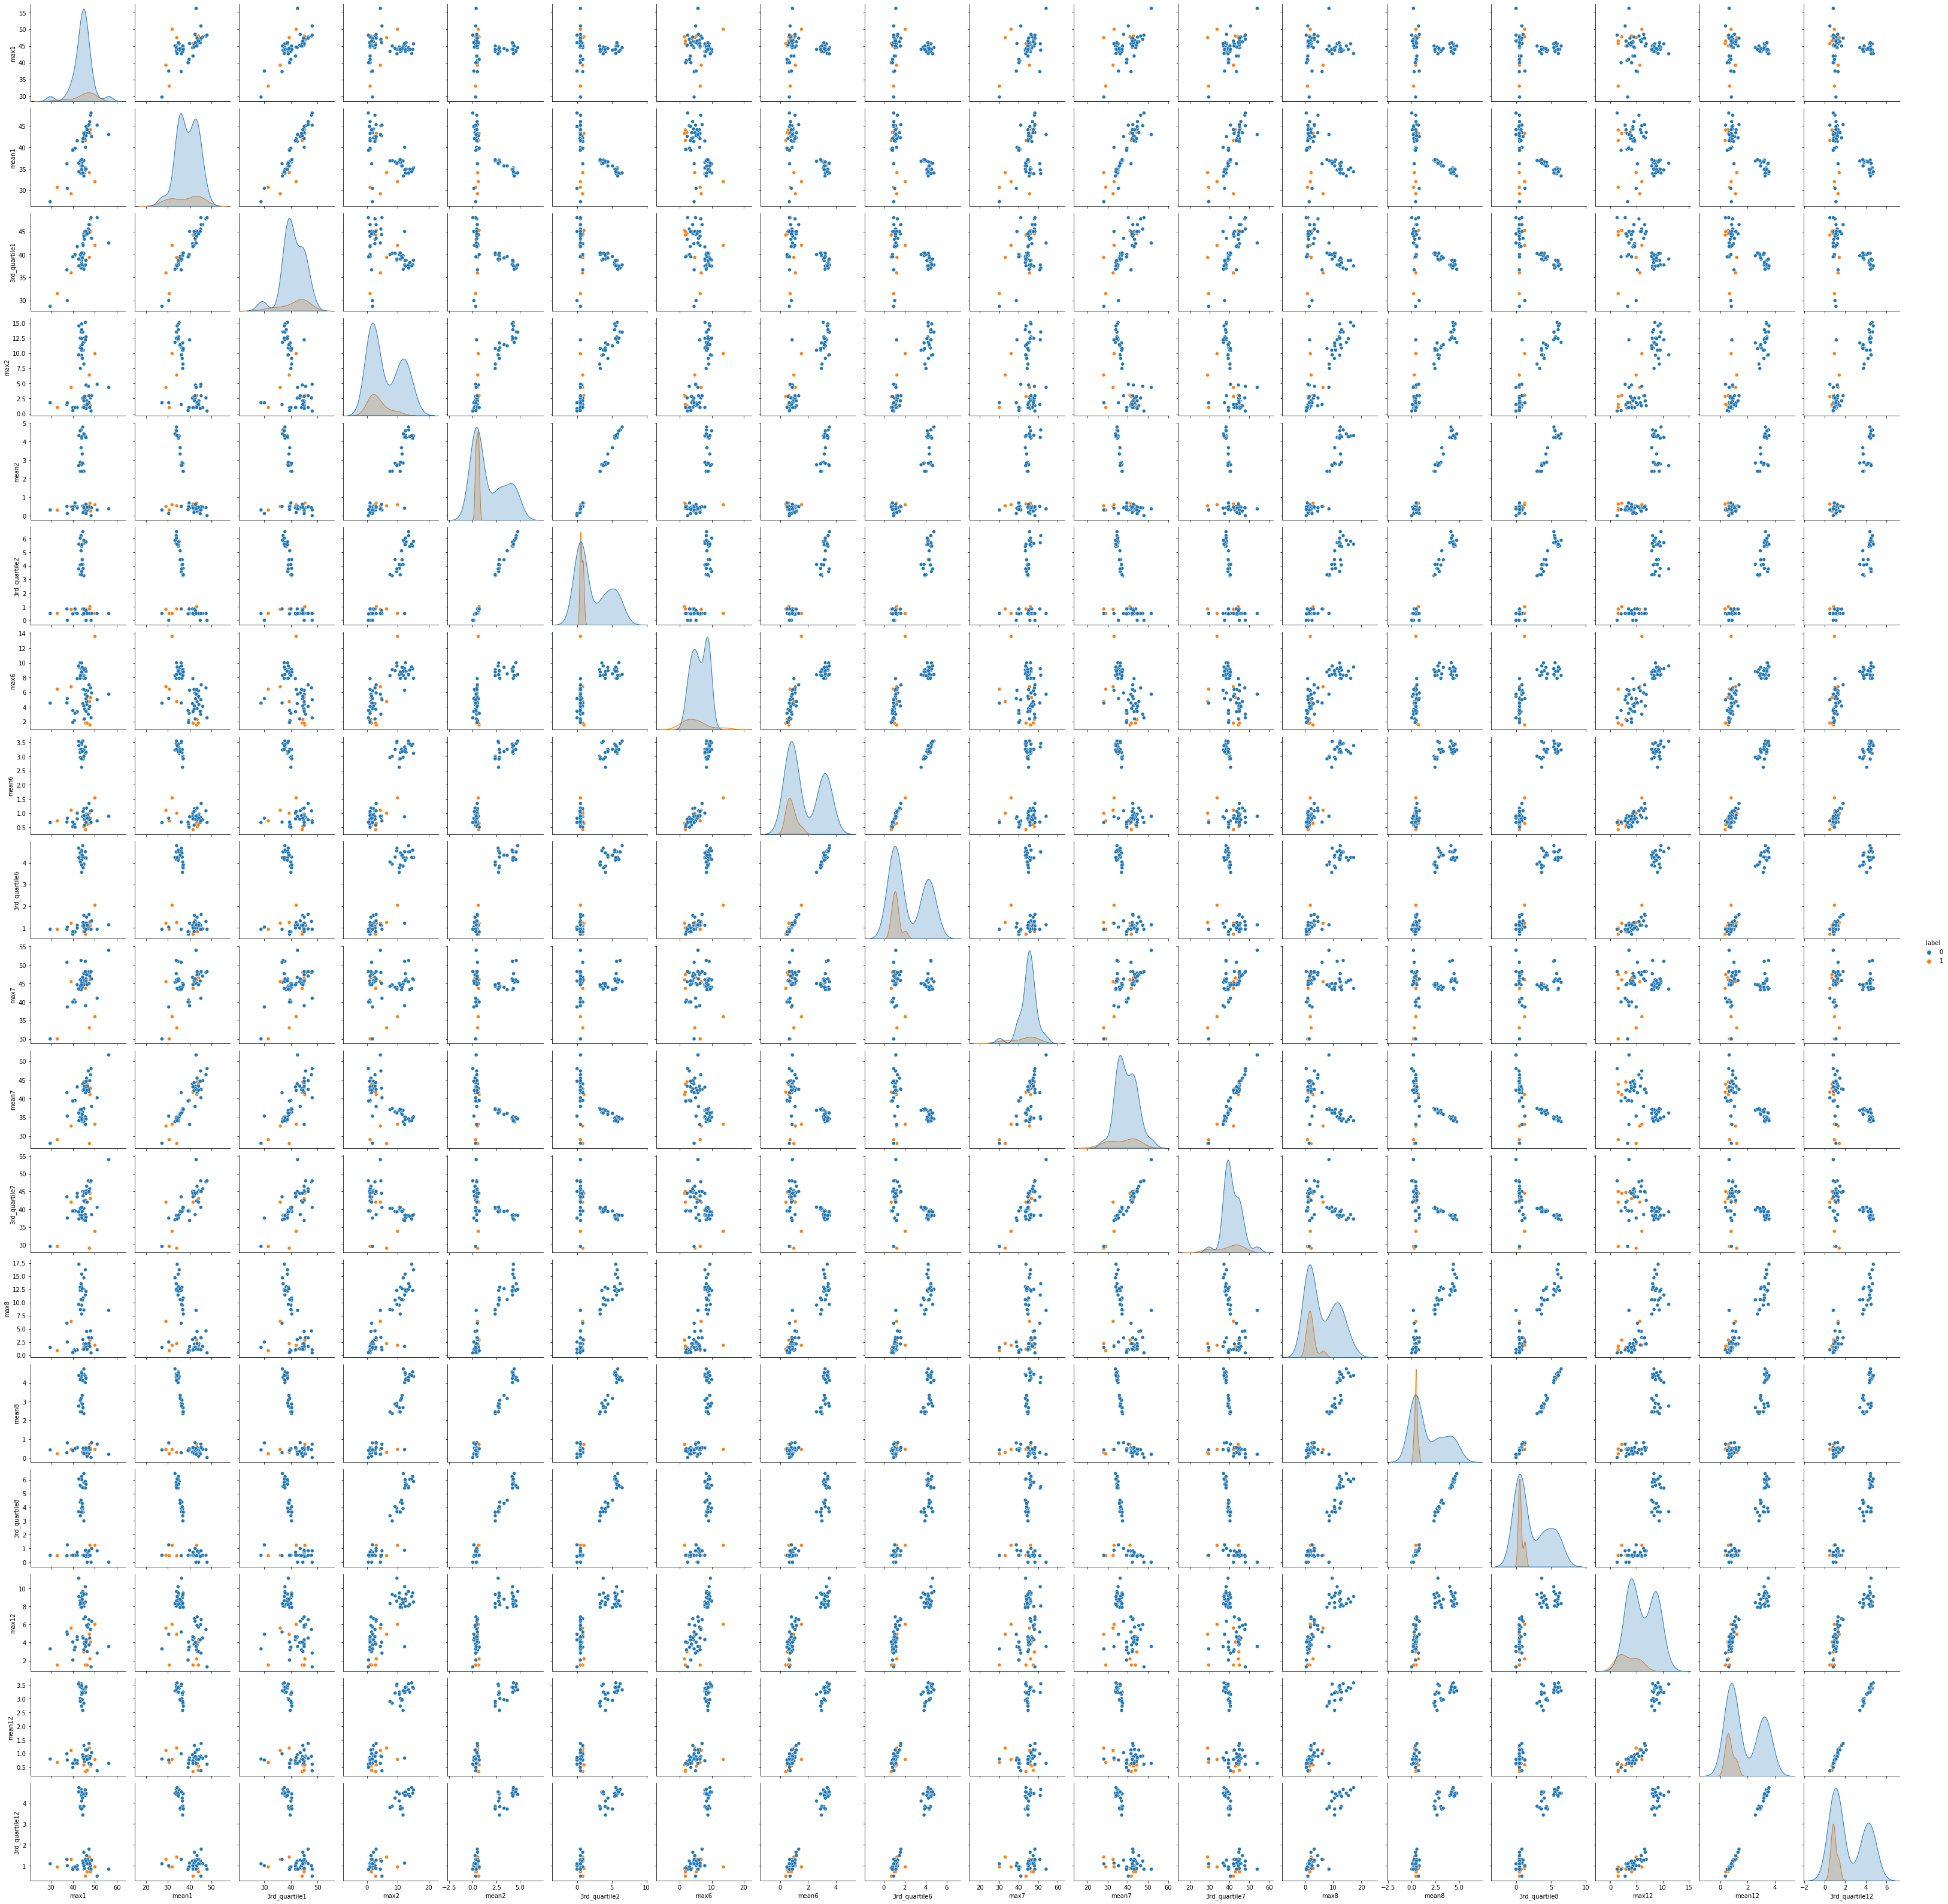

In [22]:
relevant_columns_two = get_cols([1, 2, 6, 7, 8, 12], ['max', 'mean', '3rd_quartile'])
relevant_columns_labelled_two = get_labelled_cols(train_data, relevant_columns_two)
relevant_df_two = train_data_two[relevant_columns_labelled_two]
plot_scatter_plot(relevant_df_two, 'label')

**Observation**
> Both of the results seem to be almost the same on first glance. There is no significant difference between the two.

**2a.iii) Break each time series in your training set into l in set {1, 2, ..., 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.
Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.
In the following, you can see an example of applying Python's Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.**

In [23]:
def get_features(stats, range_end):
    features = []
    for i in range(1, range_end):
        for stat in stats:
            features.append(f'{stat}{i}')
    return features

In [24]:
def oversample_data_set(data_set):
    print('Performing oversampling of dataset...')
    label_0 = data_set.loc[data_set['label'] == "0"].shape[0]
    label_1 = data_set.loc[data_set['label'] == "1"].shape[0]
    minor_count = min(label_0, label_1)
    major_count = max(label_0, label_1)
    
    if label_0 > label_1:
        minor_label = "1"
        major_label = "0"
    else:
        minor_label = "0"
        major_label = "1"
        
    minor_ds = data_set[data_set['label'] == minor_label]
    major_ds = data_set[data_set['label'] == major_label]
    minor_ds = resample(minor_ds, replace=True, random_state=60, n_samples=max(label_0, label_1))
    data_set = pd.concat([major_ds, minor_ds])
    return data_set

In [25]:
def convert_text_labels_to_boolean(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    df.loc[temp != "1", 'label'] = "0"
    return df

In [26]:
def get_data_X_Y(data_set):
    dataX = data_set.iloc[:, :-1]
    dataY = data_set.iloc[:, -1]
    return dataX, dataY

In [27]:
def logistic_regression(train_files, test_files, l_val, fold_count, oversample=False, penalty='none'):
    print(f'Running Logistic Regression for l-value {l_val}')
    features = get_features(ORDERED_STATS, 6 * l_val + 1)
    train_set = load_data(train_files, features, OG_COLUMN_NAMES, segs=l_val)
    train_set = convert_text_labels_to_boolean(pd.DataFrame(train_set))
    
    if oversample:
        train_set = oversample_data_set(train_set)
    
    trainX, trainY = get_data_X_Y(train_set)
    
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    return model, selector

In [28]:
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=False)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Running Logistic Regression for l-value 1
Running Logistic Regression for l-value 2
Running Logistic Regression for l-value 3
Running Logistic Regression for l-value 4
Running Logistic Regression for l-value 5
Running Logistic Regression for l-value 6
Running Logistic Regression for l-value 7
Running Logistic Regression for l-value 8
Running Logistic Regression for l-value 9
Running Logistic Regression for l-value 10
Running Logistic Regression for l-value 11
Running Logistic Regression for l-value 12
Running Logistic Regression for l-value 13
Running Logistic Regression for l-value 14
Running Logistic Regression for l-value 15
Running Logistic Regression for l-value 16
Running Logistic Regression for l-value 17
Running Logistic Regression for l-value 18
Running Logistic Regression for l-value 19
Running Logistic Regression for l-value 20


pair(l, p)   score
0      (1, 6)  1.0000
1      (2, 5)  0.9429
2      (3, 7)  0.9857
3      (4, 9)  0.9714
4      (5, 3)  0.9857
5     (6, 36)  0.9857
6     (7, 16)  0.9714
7     (8, 31)  0.9714
8     (9, 43)  0.9857
9    (10, 47)  0.9714
10    (11, 9)  0.9857
11   (12, 85)  0.9857
12   (13, 12)  0.9857
13   (14, 15)  0.9714
14   (15, 37)  0.9857
15   (16, 12)  0.9857
16   (17, 11)  0.9857
17    (18, 9)  0.9857
18   (19, 10)  0.9857
19   (20, 11)  0.9857

**Observation:**

> - The purpose of cross-validation is to estimate the error on test data. We do not want to deprive our algorithm with the knowledge of the various predictors available at the disposal of our dataset. Hence, the correct way would be to do the Recursive Feature Elimination along with Cross Validation.
> - The other way round, i.e. RFE before performing Cross Validation is the wrong way.

**2a.iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression betas as well as the p-values associated with them.**

In [29]:
def get_selected_features(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

In [30]:
# Extracting the selected features
l_value = 1
fold_count = 5
features = get_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train, test, l_value, fold_count)
selected_features = get_selected_features(features, selector)
selected_features

Running Logistic Regression for l-value 1


['mean1', '3rd_quartile1', 'max2', 'min5', 'max5', '1st_quartile5']

In [31]:
# p-value calculation using statmodel package
train_set = load_data(train, selected_features, OG_COLUMN_NAMES, segs=1)
train_set = convert_text_labels_to_boolean(pd.DataFrame(train_set))
trainX, trainY = get_data_X_Y(train_set)
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype=float))
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 17 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        22:30:44   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

In [32]:
# utility method to plot the ROC curve and AUC
def plot_roc_curve(actualY, predictedY_prob, classifier):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC curves")
    for i, clazz in enumerate(classifier.classes_):
        y_predicted = predictedY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label=clazz)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {clazz}; ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [33]:
# utility method to perform classification and plot the ROC curve together
def classification_and_roc_calculation(dataX, dataY, selected_features, isTest=False):
    if not isTest:
        classifier.fit(dataX.loc[:, selected_features], dataY.to_numpy(dtype="int"))
    predictY = classifier.predict(dataX.loc[:, selected_features])
    
    predictY_prob = classifier.predict_proba(dataX.loc[:, selected_features])
    y_true = dataY.to_numpy(dtype=float)
    y_pred = predictY.round()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    plot_roc_curve(y_true, predictY_prob, classifier)

[[60  0]
 [ 0  9]]


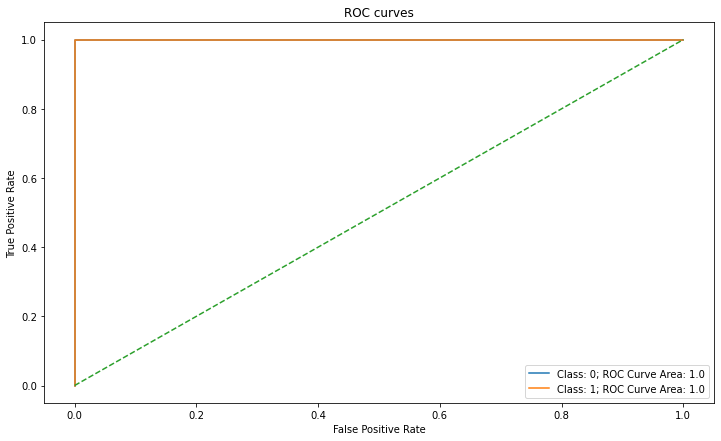

In [34]:
classification_and_roc_calculation(trainX, trainY, selected_features)

**2a.v) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.**

In [35]:
test_set = load_data(test, selected_features, OG_COLUMN_NAMES, segs=1)
test_set = convert_text_labels_to_boolean(pd.DataFrame(test_set))
testX, testY = get_data_X_Y(test_set)
testX

mean1  3rd_quartile1   max2   min5   max5  1st_quartile5
0   40.624792        42.0000   1.30  27.25  38.25        33.0000
1   42.812812        43.6700   1.22  27.67  38.50        32.0000
2   34.227771        37.7500  14.50   6.75  26.00        14.7500
3   33.509729        36.7500  13.05   7.25  25.00        14.6275
4   34.660583        38.2500  13.44   7.00  24.50        14.2500
5   24.562958        26.5000   6.87  10.67  30.00        20.5000
6   27.464604        30.0000   7.76   0.00  33.00        15.0000
7   44.334729        46.5000   3.90   0.00  23.00         9.3300
8   43.174938        44.5000   2.12   2.00  21.25        12.7500
9   42.760563        45.3725   3.34   1.33  21.33        13.0000
10  42.363563        43.5000   4.44   1.00  28.00        10.1875
11  45.917667        46.5000   4.87   2.00  24.00        16.5000
12  45.239667        45.3300   1.00   4.75  26.75        17.6275
13  27.716375        29.0000   1.79   0.00  21.00         5.5000
14  44.182937        48.0000   3.11   0.00  12.75         2.0000
15  48.004167        48.0000   0.43   0.00  12.00         4.6700
16  37.177042        40.2500   8.58   7.00  25.50        17.9500
17  37.561188        40.2500   9.91  10.50  24.33        18.0000
18  37.058708        40.0625  14.17   7.50  24.25        16.0000

[[15  0]
 [ 0  4]]


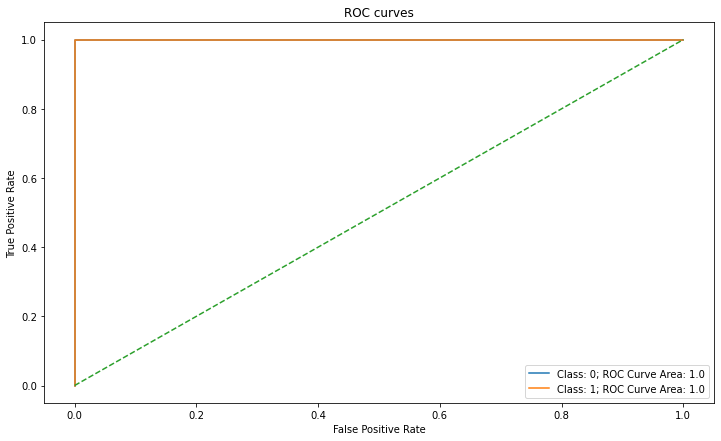

In [36]:
classification_and_roc_calculation(testX, testY, selected_features, isTest=True)

**Observation:**
> The accuracy for test as well as cross validation seems to be almost same.

**2a.vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?**

**Observations:**
> - The p-value analysis using statmodel suggests that there is Complete Separation. It further does on to suggest that the results show that there iscomplete separation. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.
> - Due to this finding, it is possible that the well-separation of the classes is cauisng the instability in calculation o fthe regression parameters.

**2a.vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.**

**Observations:**
> According to my assignment, 0 = non-bending classes and 1 = bending classes. I can see, according to the confusion matrices, that there are 69 instances of non-bending classes and 9 instances for bending classes which goes to show that the classes are definitely imbalanced.
Since the answer to the above observation is yes, it means that we will have to build a regression model on case-controlled sampling i.e. we will have to oversample.

In [37]:
# Logistic Regression with oversampling
print("Performing logistic regression with oversampling=True")
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=True)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Performing logistic regression with oversampling=True
Running Logistic Regression for l-value 1
Performing oversampling of dataset...
Running Logistic Regression for l-value 2
Performing oversampling of dataset...
Running Logistic Regression for l-value 3
Performing oversampling of dataset...
Running Logistic Regression for l-value 4
Performing oversampling of dataset...
Running Logistic Regression for l-value 5
Performing oversampling of dataset...
Running Logistic Regression for l-value 6
Performing oversampling of dataset...
Running Logistic Regression for l-value 7
Performing oversampling of dataset...
Running Logistic Regression for l-value 8
Performing oversampling of dataset...
Running Logistic Regression for l-value 9
Performing oversampling of dataset...
Running Logistic Regression for l-value 10
Performing oversampling of dataset...
Running Logistic Regression for l-value 11
Performing oversampling of dataset...
Running Logistic Regression for l-value 12
Performing oversampli

pair(l, p)   score
0      (1, 4)  1.0000
1      (2, 7)  0.9833
2      (3, 3)  1.0000
3      (4, 3)  0.9917
4      (5, 3)  0.9917
5      (6, 3)  0.9917
6      (7, 2)  0.9917
7      (8, 3)  0.9917
8      (9, 9)  1.0000
9     (10, 5)  0.9917
10    (11, 2)  0.9917
11    (12, 8)  1.0000
12    (13, 4)  1.0000
13    (14, 7)  1.0000
14    (15, 9)  1.0000
15    (16, 8)  1.0000
16    (17, 4)  1.0000
17    (18, 3)  1.0000
18    (19, 6)  1.0000
19    (20, 5)  1.0000

In [38]:
l_value = 1
fold_count = 5
features = get_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train, test, l_value, fold_count, oversample=True)
selected_features = get_selected_features(features, selector)
selected_features

Running Logistic Regression for l-value 1
Performing oversampling of dataset...


['3rd_quartile1', 'min5', 'max5', 'mean5']

Performing oversampling of dataset...
[[60  0]
 [ 0 60]]


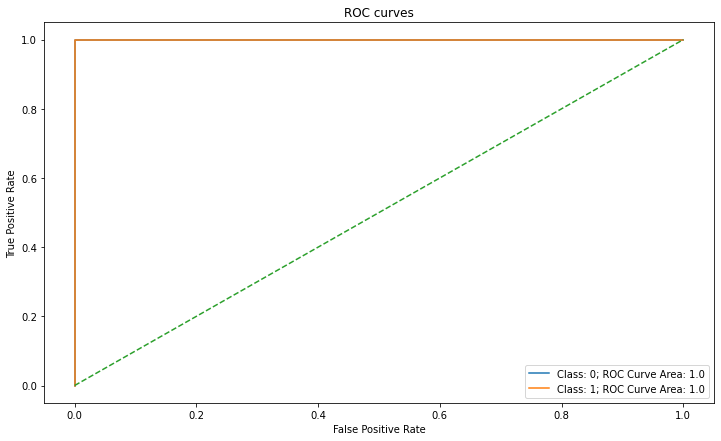

In [39]:
train_set = load_data(train, selected_features, OG_COLUMN_NAMES, segs=1)
train_set = convert_text_labels_to_boolean(pd.DataFrame(train_set))
train_set = oversample_data_set(train_set)
trainX, trainY = get_data_X_Y(train_set)
classification_and_roc_calculation(trainX, trainY, selected_features)

[[15  0]
 [ 0  4]]


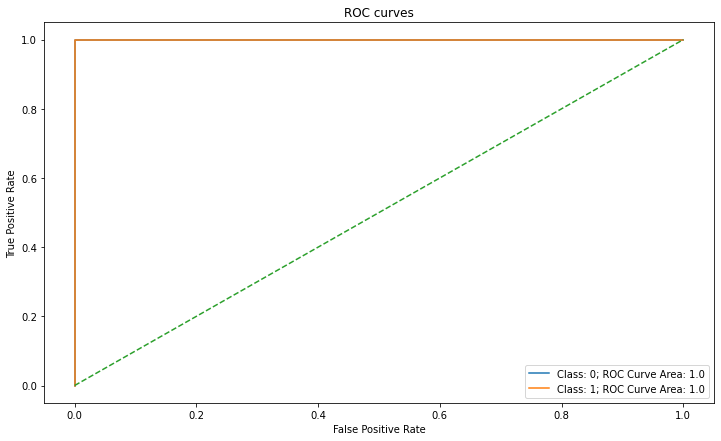

In [40]:
test_set = load_data(test, selected_features, OG_COLUMN_NAMES, segs=1)
test_set = convert_text_labels_to_boolean(pd.DataFrame(test_set))
# test_set = oversample_data_set(test_set)
testX, testY = get_data_X_Y(test_set)
classification_and_roc_calculation(testX, testY, selected_features)

## 2b) Binary Classification Using L1-penalized logistic regression

**2b-i) Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and lambda, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for lambda automatically.**

In [41]:
max_test_accuracy = 0
optimal_L = 1

In [42]:
# utility  method for performing regression based on the given classifier
def perform_regression_with_classifier(classifier, classifier_name, l_val, kwargs, penalty='none', 
                              is_binary_classification=True, draw_roc=False):
    print(f'Running {classifier_name} for l-value {l_val}')
    features = get_features(ORDERED_STATS, 6 * l_val + 1)
    train_set = load_data(train, features, OG_COLUMN_NAMES, segs=l_val)
    test_set = load_data(test, features, OG_COLUMN_NAMES, segs=l_val)
    
    if is_binary_classification:
        train_set = get_binary_labelled_dataframe(pd.DataFrame(train_set))
        test_set = get_binary_labelled_dataframe(pd.DataFrame(test_set))
        
    trainX, trainY = get_data_X_Y(train_set)
    testX, testY = get_data_X_Y(test_set)
    
    if is_binary_classification:
        # https://stackoverflow.com/questions/45346550/valueerror-unknown-label-type-unknown
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    classifier2 = classifier(**kwargs)
    classifier2.fit(trainX, trainY)
    
    if not draw_roc:    
        train_score = round(classifier2.score(trainX, trainY), 4)
        test_score = round(classifier2.score(testX, testY), 4)
        print(f'Value of L: {l_val} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_val} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'The maximum accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
            print(f'Further calculations will be done with L-value: {optimal_L}')
        
    else:
        train_predictY_prob = classifier2.predict_proba(trainX)
        test_predictY_prob = classifier2.predict_proba(testX)

        predictY = classifier2.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        print("ROC Curve for Train Data")
        plot_roc_curve(trainY, train_predictY_prob, classifier2)
        
        print("ROC Curve for Test Data")
        plot_roc_curve(testY, test_predictY_prob, classifier2)

In [43]:
# making use of the varargs concept
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

fold_count = 5

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV,
                                       "Logistic Regression", 
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=True, 
                                       draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 1.0
Value of L: 2 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.9474
Value of L: 4 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.9474
Value of L: 5 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.9474
Value of L: 6 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 1.0
Value of L: 7 | tra

Running Logistic Regression for l-value 1
Confusion matrix for test data:
[[15  0]
 [ 0  4]]
ROC Curve for Train Data


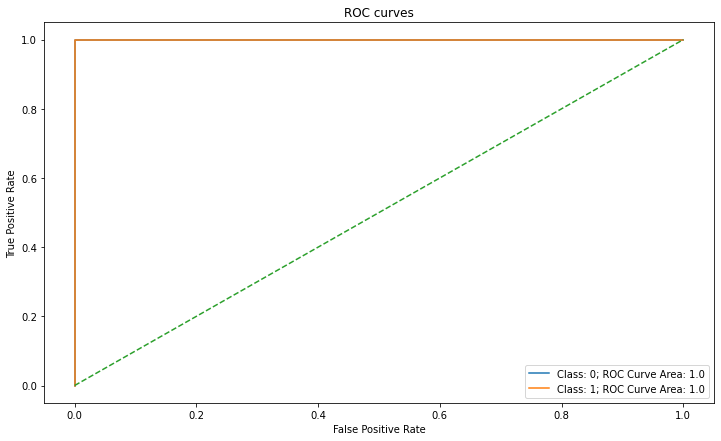

ROC Curve for Test Data


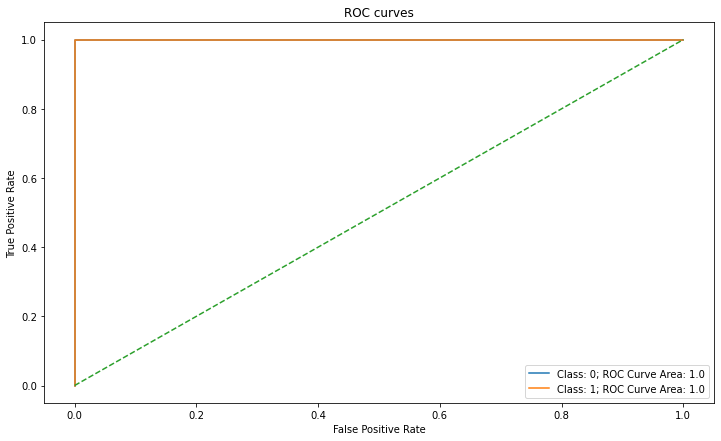

In [44]:
# making use of the varargs concept
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

fold_count = 5
best_l = 1

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(LogisticRegression,
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=True, 
                                   draw_roc=True)

**2b-ii) Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?**

**Observations:**
> - The L1-penalized logistic regression has better performance in terms of accuracy when tested on the test data (approximately ~ 1.0) and hence, the L1-penalized performs better. THe L1-regularization is easier to implement as feature selection does not need to be manual.

## 2c) Multi-class Classification (The Realistic Case)

**2c-i) Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.**

In [45]:
# making use of the varargs concept
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class': 'multinomial',
    'cv': 5,
    'random_state' : 69,
    'solver' : 'saga'
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV, 
                                       "Logistic Regression",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.9474
Value of L: 2 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.8421
Value of L: 3 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.8947
Value of L: 4 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.8421
Value of L: 5 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.7895
Value of L: 6 | train_error: 0.0 | test_error: 0.2105

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.736

Running Logistic Regression for l-value 2
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


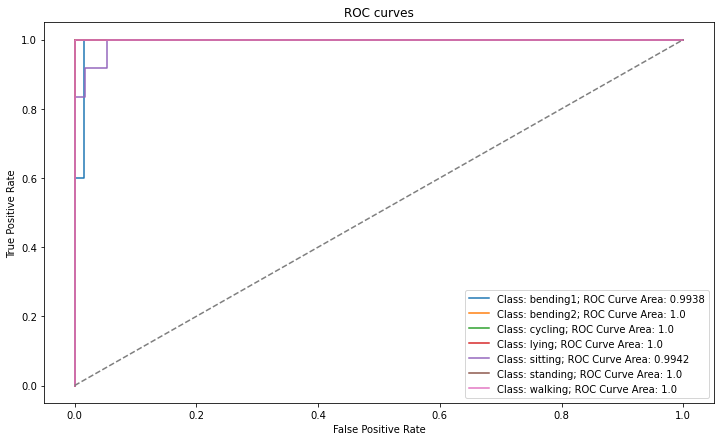

ROC Curve for Test Data


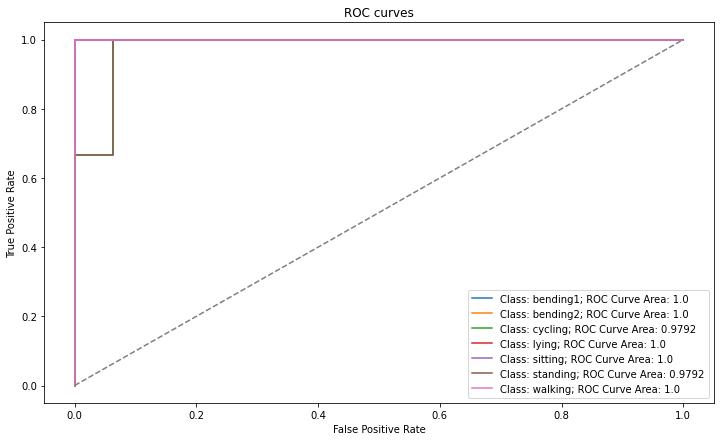

In [46]:
# making use of the varargs concept
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial',
    'solver' : 'saga'
}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(LogisticRegression, 
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

**2c-ii) Repeat 2(c)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.**

In [47]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(GaussianNB, 
                                       "Naive Bayes Classifier with Gaussian Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Naive Bayes Classifier with Gaussian Prior for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.6316
Value of L: 2 | train_error: 0.0 | test_error: 0.3684

Running Naive Bayes Classifier with Gaussian Prior for l-value 3
Value of L: 3 | train_score: 0.9855 | test_score: 0.7368
Value of L: 3 | train_error: 0.0145 | test_error: 0.2632

Running Naive Bayes Classifier with Gaussian Prior for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.7895
Value of L: 4 | train_error: 0.0 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 5
Value of L: 5 | train_score: 0.9855 | test_score: 0.7895
Value of L: 5 | train_error: 0.0145 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 6
Value of L: 6 | train_score: 0.971 | test_score: 0.63

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


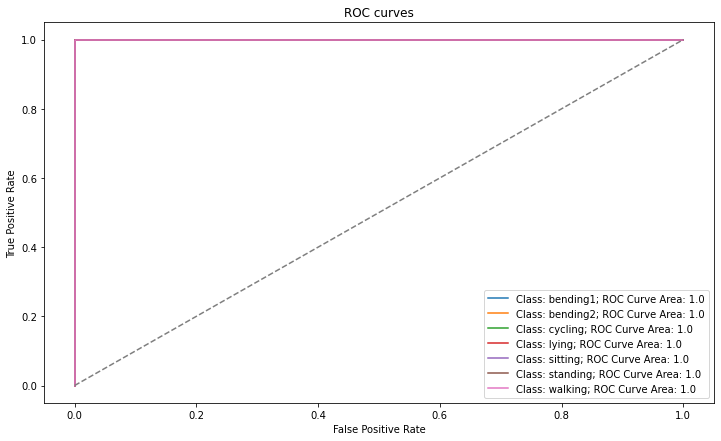

ROC Curve for Test Data


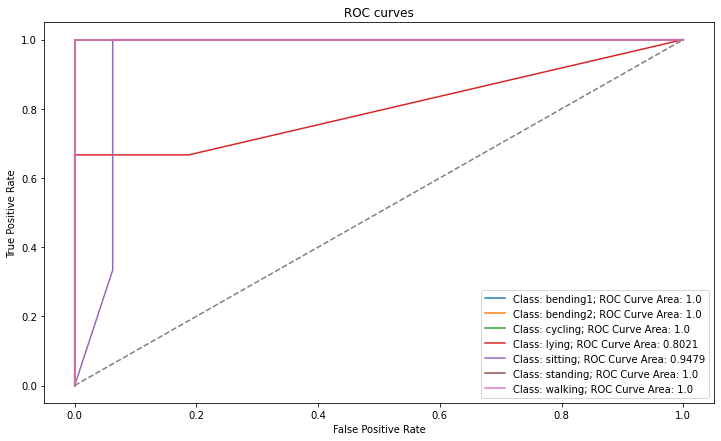

In [48]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(GaussianNB, 
                                   "Naive Bayes Classifier with Gaussian Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

In [49]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(MultinomialNB, 
                                       "Naive Bayes Classifier with Multinomial Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Value of L: 1 | train_score: 0.9275 | test_score: 0.8947
Value of L: 1 | train_error: 0.0725 | test_error: 0.1053

Running Naive Bayes Classifier with Multinomial Prior for l-value 2
Value of L: 2 | train_score: 0.8841 | test_score: 0.7368
Value of L: 2 | train_error: 0.1159 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 3
Value of L: 3 | train_score: 0.8986 | test_score: 0.7895
Value of L: 3 | train_error: 0.1014 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.7895
Value of L: 4 | train_error: 0.087 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 5
Value of L: 5 | train_score: 0.9275 | test_score: 0.7368
Value of L: 5 | train_error: 0.0725 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 6
Value of L: 6 | tra

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


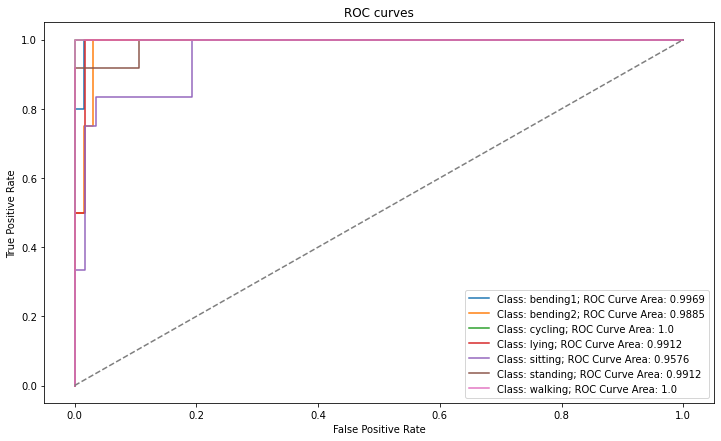

ROC Curve for Test Data


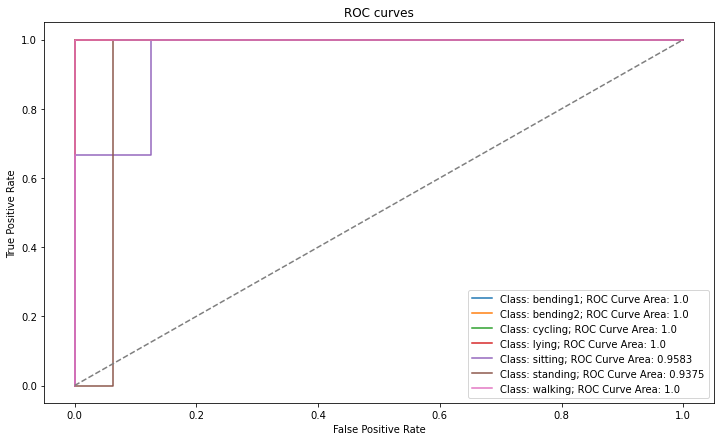

In [50]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(MultinomialNB, 
                                   "Naive Bayes Classifier with Multinomial Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

**2c-iii) Which method is better for multi-class classification in this problem?**

**Observations:**
> The area under the ROC curve (AUC) is relatively better for the Logistic Regression curve than any other classifer prior (Gaussian or Multinomial) and hence, I would say that Logistic Regression has better classification for the given dataset

# 3) ISLR 4.8.3

**This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a classspecific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature. Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk, σ2k). Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.**

**Hint: For this problem, you should follow the arguments laid out in Section 4.4.2, but without making the assumption that σ21 = ... = σ2K.**

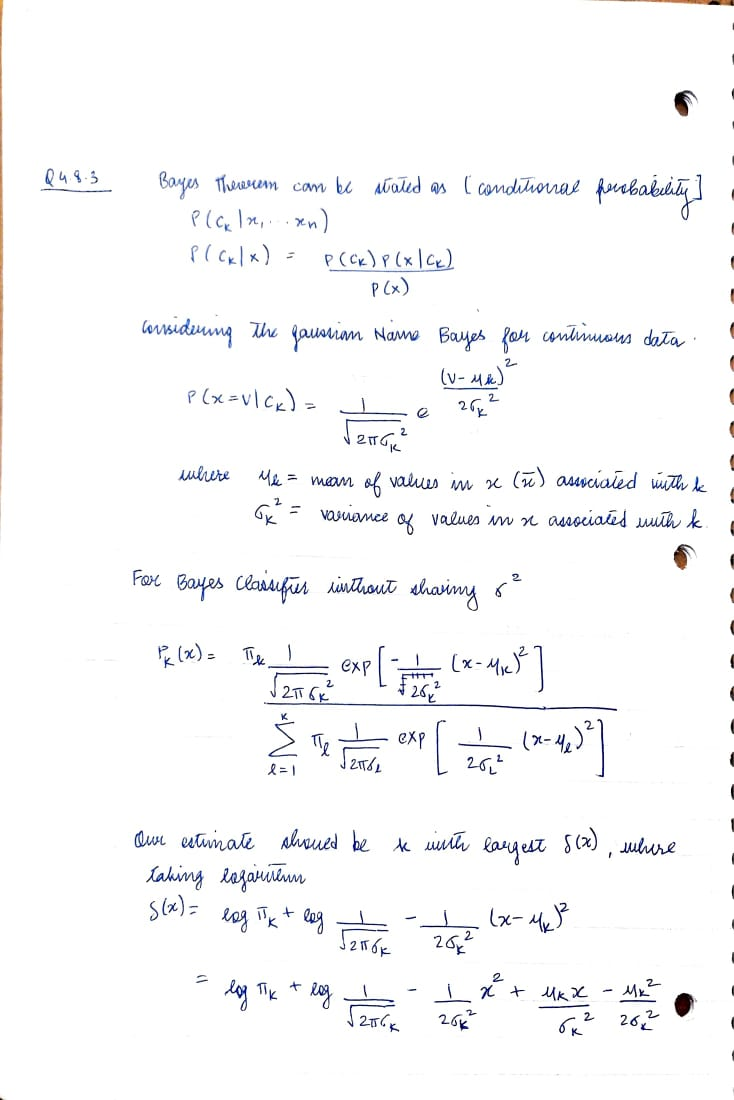

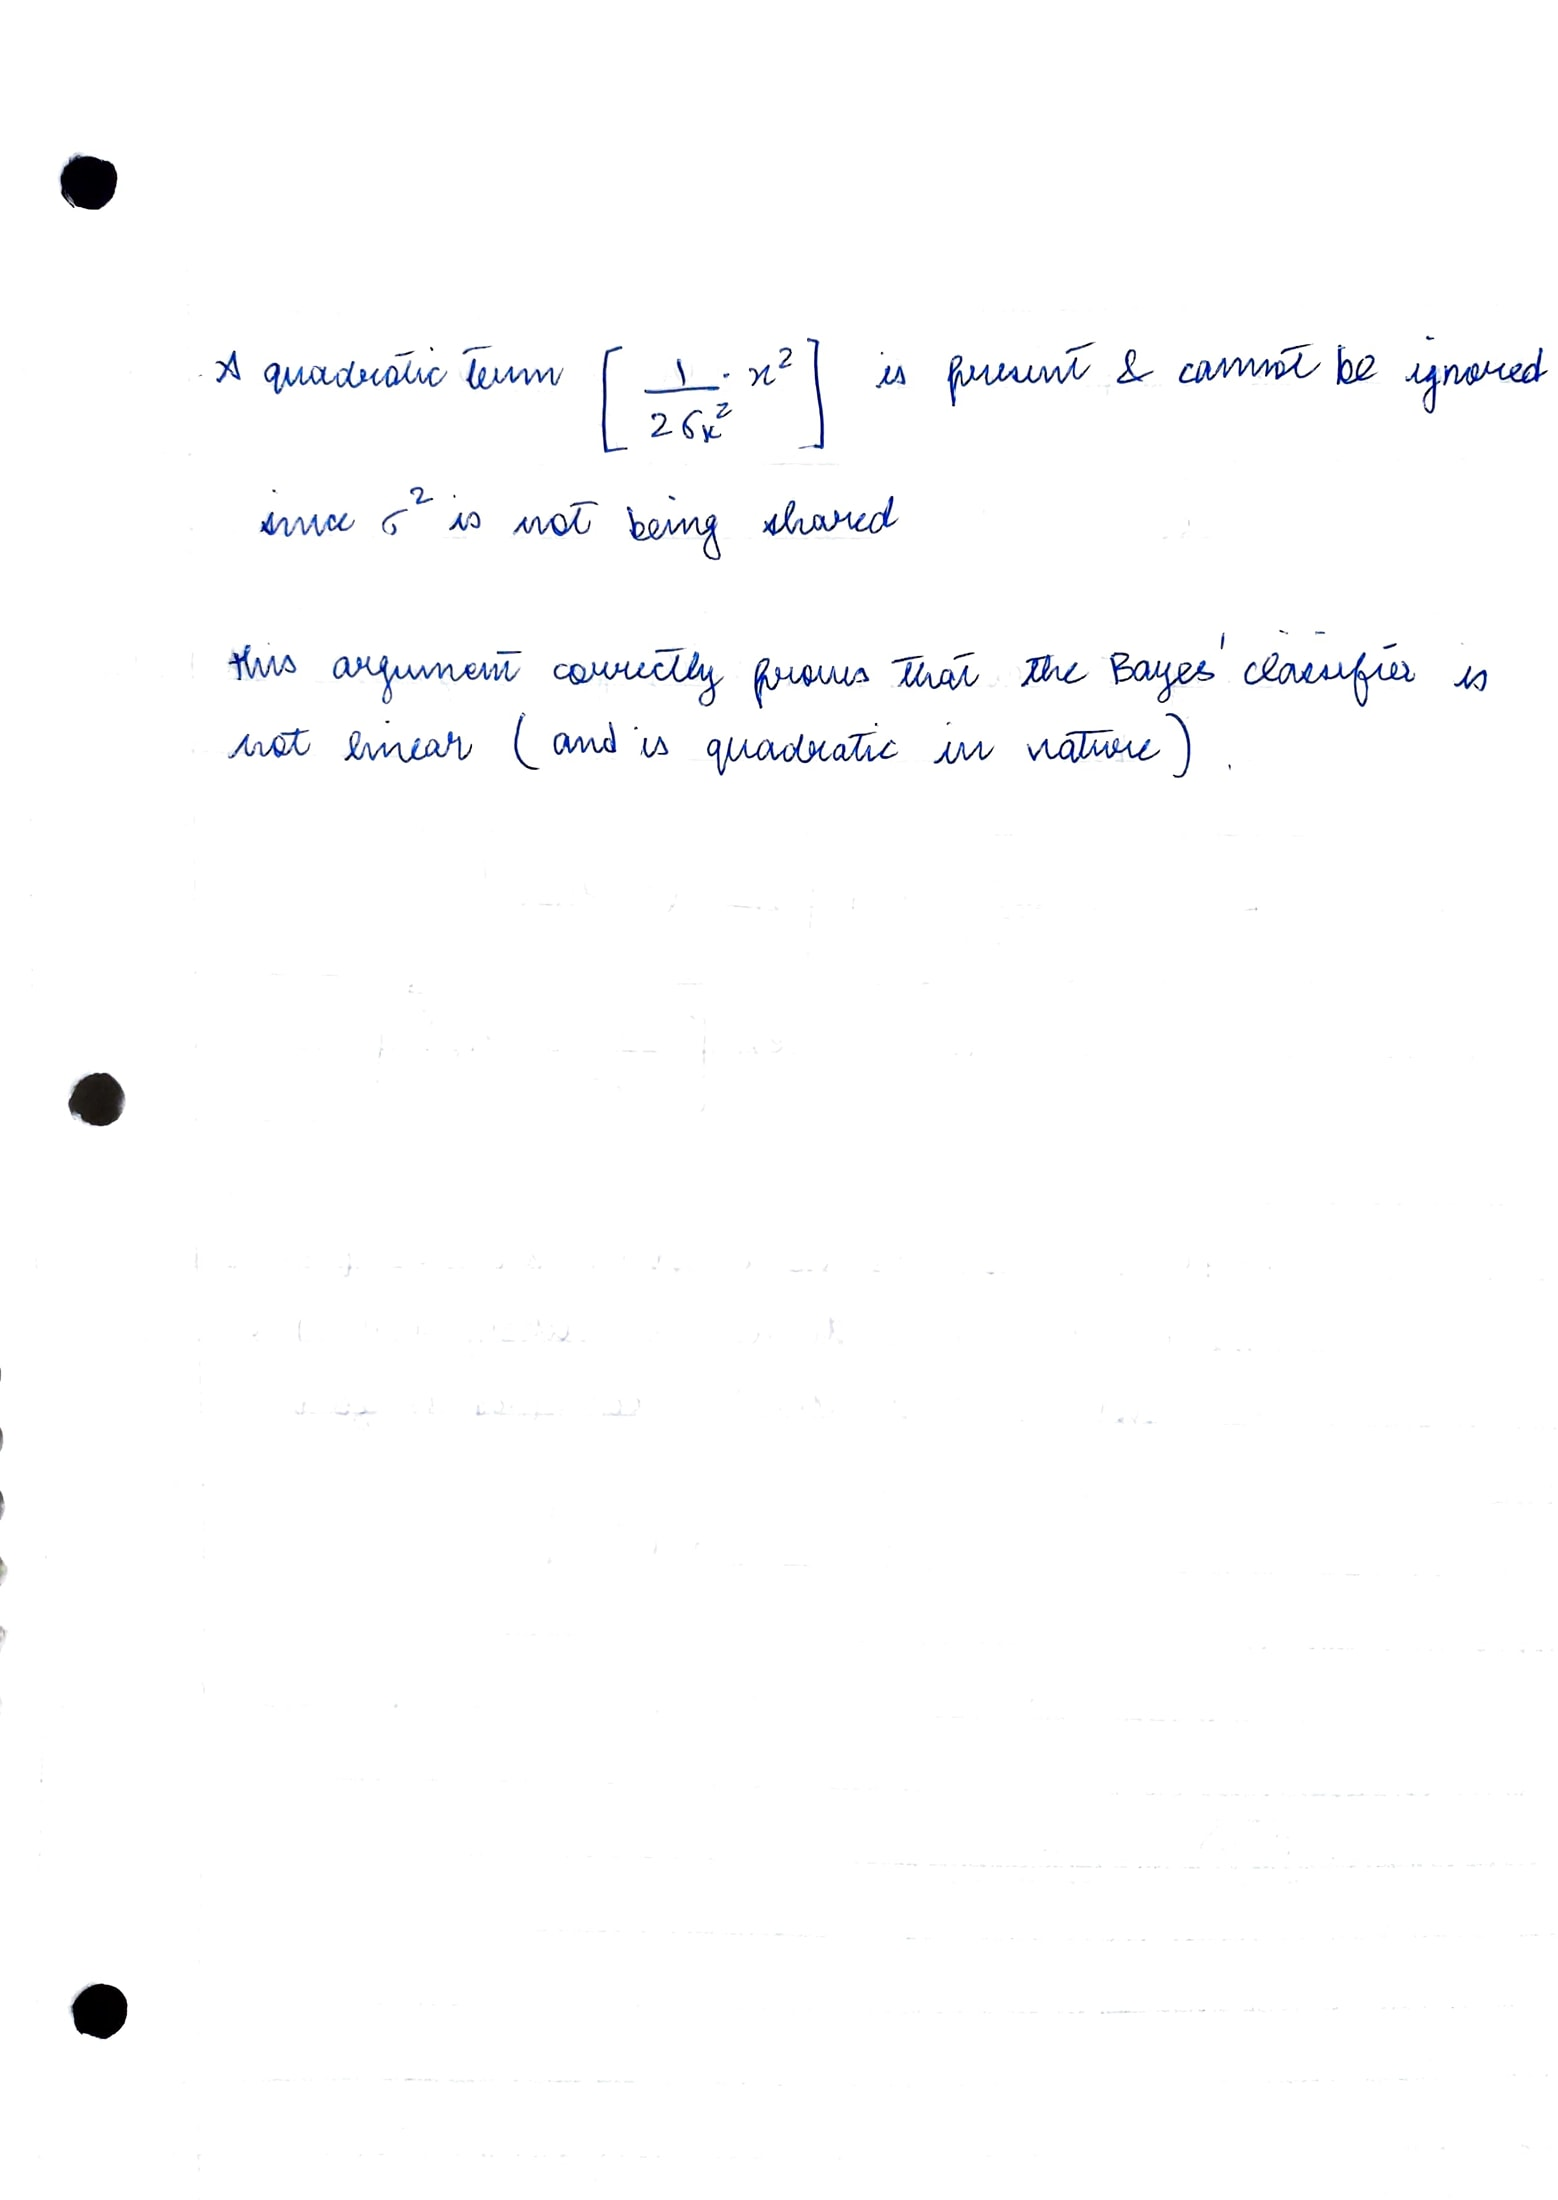

# 4) ISLR 4.8.7


**Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X¯ = 10, while the mean for those that didn’t was X¯ = 0. In addition, the variance of X for these two sets of companies was ˆσ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year**

**Hint: Recall that the density function for a normal random variable
is f(x) = √1
2πσ2 e−(x−μ)2/2σ2. You will need to use Bayes’ theorem.**


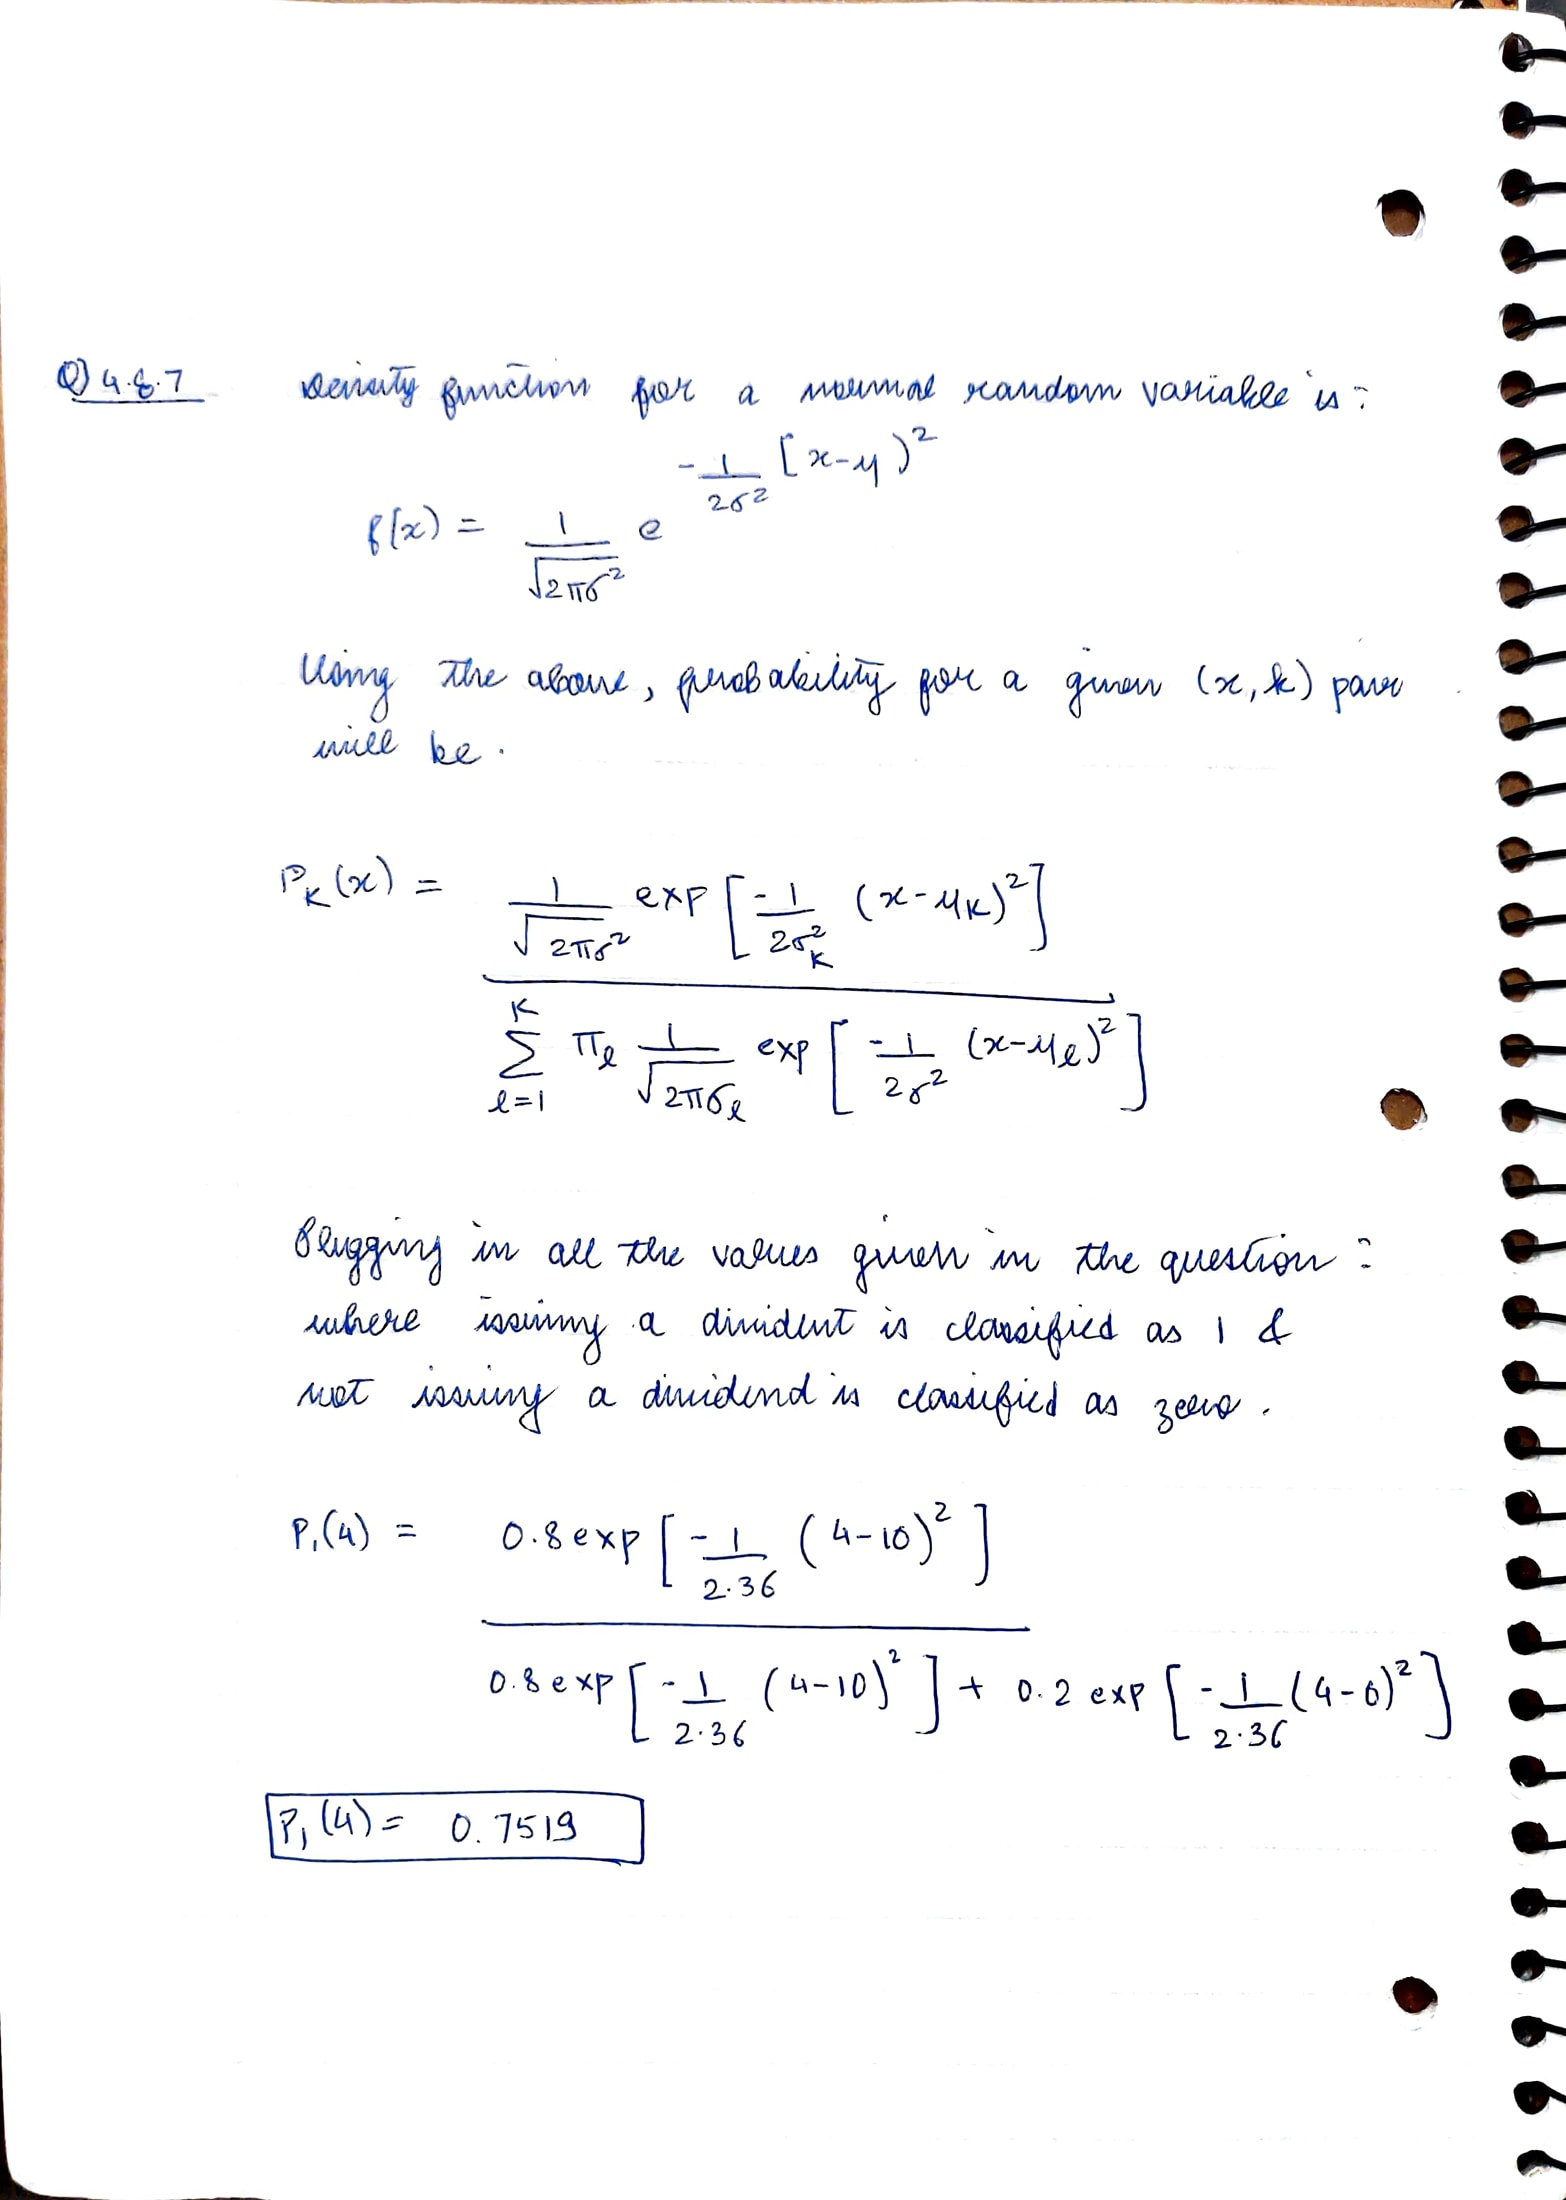

**References:**
> - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
> - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
> - https://www.statsmodels.org/stable/index.html
> - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
> - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html